In [1]:
"""
This experiment uses hashprint with delta features that won't change weights.
"""

"\nThis experiment uses hashprint with delta features that won't change weights.\n"

In [2]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-100-iteration-dropout-delta-notrain]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = False      # Set to True if you want to see the loss function per epoch in real time

In [3]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer, GaussianNoise, BatchNormalization
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mjenrungrot/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [5]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-08 13:20:18,656 - root - DEBUG - Keras backend is tensorflow.
2018-03-08 13:20:18,658 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [6]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

songPairs = []
totalPairs = 0 
for ref, query in ref_query_pairs:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-03-08 13:20:18,715 - root - DEBUG - Load Paired-annotation data
2018-03-08 13:20:18,716 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-08 13:20:18,717 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7f2de024ceb8>}


/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.d

2018-03-08 13:20:42,983 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 76, 121)
2018-03-08 13:20:42,985 - root - DEBUG - Number of samples for the current song: 272
2018-03-08 13:21:05,362 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 76, 121)
2018-03-08 13:21:05,364 - root - DEBUG - Number of samples for the current song: 264
2018-03-08 13:21:12,761 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-08 13:21:12,763 - root - DEBUG - Number of samples for the current song: 100
2018-03-08 13:21:20,138 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-08 13:21:20,139 - root - DEBUG - Number of samples for the current song: 100
2018-03-08 13:21:36,060 - root - DEBUG - Song 5: Finish current pairs with shape = (221, 2, 76, 121)
2018-03-08 13:21:36,063 - root - DEBUG - Number of samples for the current song: 221
2018-03-08 13:21:54,313 - root - DEBUG - Song 6: Finish current pairs 

In [7]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-03-08 13:26:33,451 - root - DEBUG - Finish loading paired-annotation data
2018-03-08 13:26:33,453 - root - DEBUG - => There are 14 songs for training [63.52 percent]
2018-03-08 13:26:33,454 - root - DEBUG - => There are 6 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [8]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [9]:
X1, X2, S, W, groundTruth = generate_training_data(data_train)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val)

2018-03-08 13:26:33,981 - root - DEBUG - X1 shape: (4237, 1, 76, 121)
2018-03-08 13:26:33,982 - root - DEBUG - X2 shape: (4237, 1, 76, 121)
2018-03-08 13:26:33,983 - root - DEBUG - S shape: (4237, 1)
2018-03-08 13:26:33,984 - root - DEBUG - W shape: (4237, 1)
2018-03-08 13:26:33,985 - root - DEBUG - There are 3237 out of 4237 pairs that are similar [76.40 percent]
2018-03-08 13:26:34,233 - root - DEBUG - X1 shape: (2859, 1, 76, 121)
2018-03-08 13:26:34,234 - root - DEBUG - X2 shape: (2859, 1, 76, 121)
2018-03-08 13:26:34,235 - root - DEBUG - S shape: (2859, 1)
2018-03-08 13:26:34,236 - root - DEBUG - W shape: (2859, 1)
2018-03-08 13:26:34,237 - root - DEBUG - There are 1859 out of 2859 pairs that are similar [65.02 percent]


In [10]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [11]:
width = 76
height = 121
n_channel = 1

In [12]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [13]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-03-08 13:26:34,633 - root - DEBUG - Load model from /data1/mint/public/taylorswift_out/model.mat


In [14]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, refQ.shape, delta=delta, compute_delta=True)
logger.debug("Construct base model")

2018-03-08 13:26:37,158 - root - DEBUG - Construct base model


In [15]:
# pop last layer
lastLayer = base_model.layers[-1]
base_model.pop()

# add dropout
base_model.add(Dropout(0.8)) # Drop 80%

# add batch normalization 
lastLayer.trainable = False
base_model.add(lastLayer)

2018-03-08 13:26:37,626 - root - DEBUG - Save base_model architecture to base_model.png


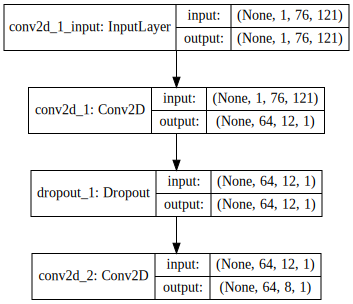

In [16]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [17]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [18]:
beta         = 1            # Initial beta value
numberOfBits = None
alpha        = 0.05         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-08 13:26:37,867 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = None, alpha = 0.05


In [19]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [20]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [21]:
activation_layer = Activation(custom_activation)
encoded_a = activation_layer(flatten_a)
encoded_b = activation_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [22]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-03-08 13:26:37,952 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [23]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [24]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-08 13:26:37,983 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-03-08 13:26:38,226 - root - DEBUG - Save model architecture to model.png


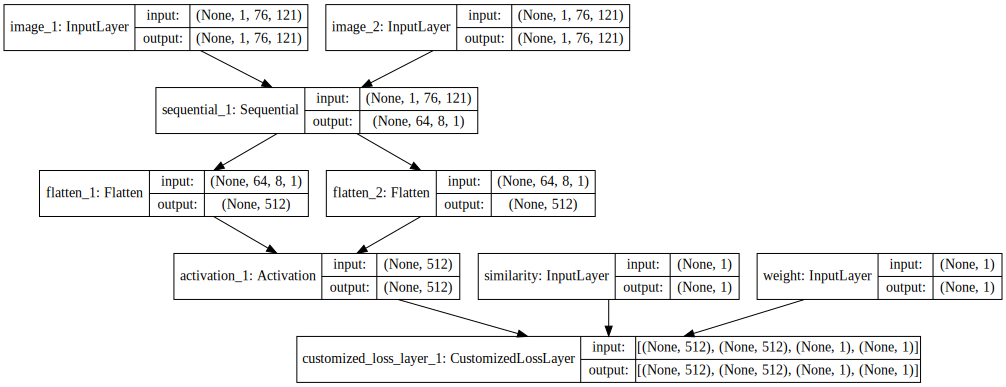

In [25]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [26]:
representation_model = Model(image_a, flatten_a)

In [27]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 400, 100)

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

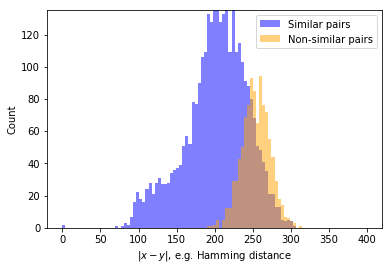

In [28]:
visualize(X1, X2, groundTruth, representation_model)

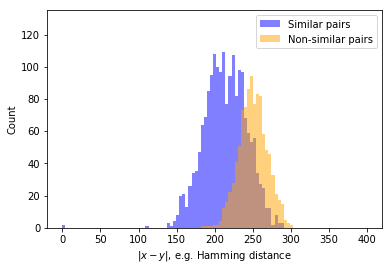

In [29]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [30]:
def visualizeFilters():
    nFilters = base_model.layers[0].get_weights()[0].shape[-1]
    plt.figure(figsize=(8,20))
    plt.tight_layout(pad=0, w_pad=0, h_pad=-10)
    for i in range(nFilters):
        filt = base_model.layers[0].get_weights()[0][:,:,0,i]
        plt.subplot(7, 10, i+1)
        plt.imshow(filt.T, cmap='jet')
        plt.xticks([])
        plt.yticks([])
    plt.show()

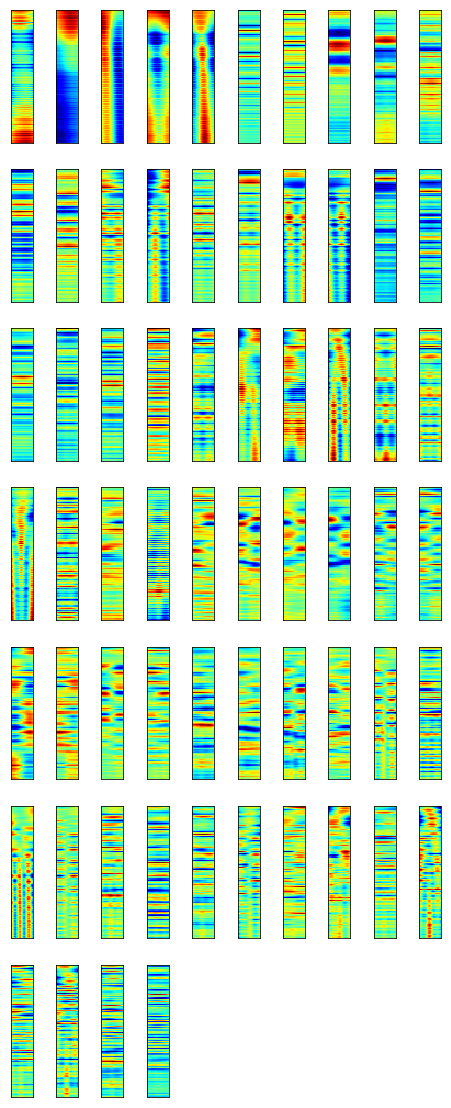

In [31]:
visualizeFilters()

## Train a model

In [32]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-08 13:26:45,568 - root - DEBUG - Ready to train the model
2018-03-08 13:26:45,569 - root - DEBUG - X1 shape: (4237, 1, 76, 121)
2018-03-08 13:26:45,570 - root - DEBUG - X2 shape: (4237, 1, 76, 121)
2018-03-08 13:26:45,571 - root - DEBUG - S shape: (4237, 1)
2018-03-08 13:26:45,572 - root - DEBUG - W shape: (4237, 1)


In [33]:
number_of_iterations = 100
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 1.5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 200
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-08 13:26:45,588 - root - DEBUG - [Training] number_of_iterations = 100
2018-03-08 13:26:45,589 - root - DEBUG - [Training] beta_factor = 1.5
2018-03-08 13:26:45,591 - root - DEBUG - [Training] number_of_epochs = 200


In [34]:
train_losses = []
test_losses = []

2859/2859 [==============================] - 1s 205us/step
2018-03-08 13:26:47,096 - root - DEBUG - [Iteration = 0] Training Loss = 38.21853116977101, Testing Loss = 43.63654446510136
2018-03-08 13:26:47,098 - root - DEBUG - Iteration 1 (current beta = 1)


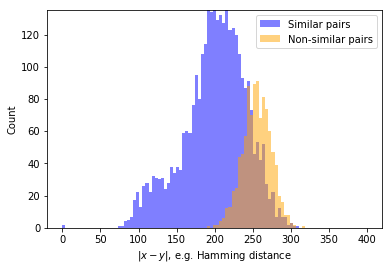

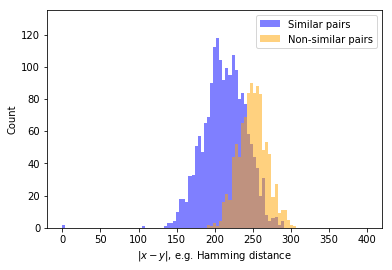

2859/2859 [==============================] - 1s 207us/step
2018-03-08 13:30:35,598 - root - DEBUG - [Iteration = 1] Training Loss = 38.15208274455588, Testing Loss = 44.472911358379996
2018-03-08 13:30:35,600 - root - DEBUG - Iteration 2 (current beta = 1.5)


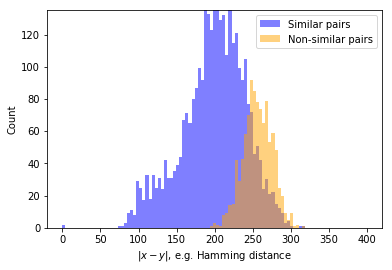

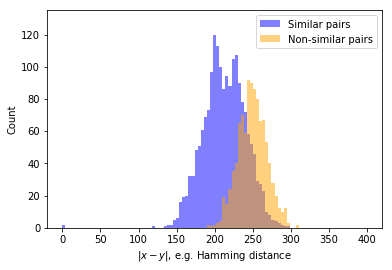

2859/2859 [==============================] - 1s 212us/step
2018-03-08 13:34:26,379 - root - DEBUG - [Iteration = 2] Training Loss = 37.58050960997163, Testing Loss = 44.743582028365296
2018-03-08 13:34:26,381 - root - DEBUG - Iteration 3 (current beta = 2.25)


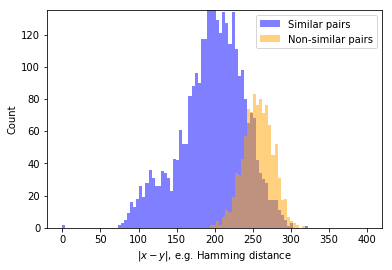

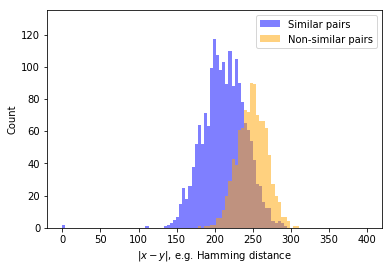

2859/2859 [==============================] - 1s 193us/step
2018-03-08 13:38:15,947 - root - DEBUG - [Iteration = 3] Training Loss = 37.675303217512464, Testing Loss = 45.36207849923528
2018-03-08 13:38:15,949 - root - DEBUG - Iteration 4 (current beta = 3.375)


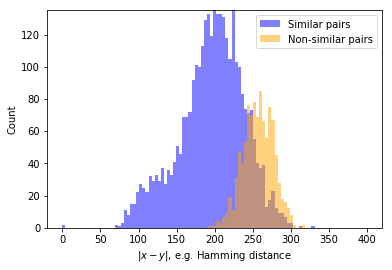

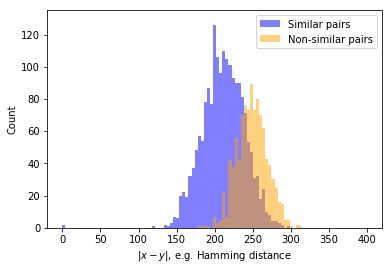

2859/2859 [==============================] - 1s 213us/step
2018-03-08 13:42:05,343 - root - DEBUG - [Iteration = 4] Training Loss = 37.80075099735227, Testing Loss = 46.09813682746954
2018-03-08 13:42:05,344 - root - DEBUG - Iteration 5 (current beta = 5.0625)


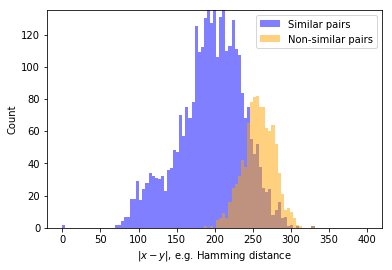

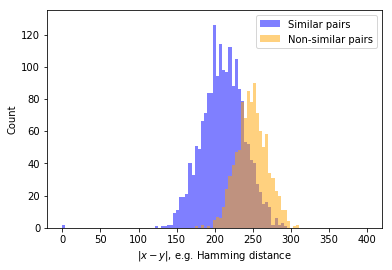

2859/2859 [==============================] - 1s 217us/step
2018-03-08 13:45:54,555 - root - DEBUG - [Iteration = 5] Training Loss = 37.55845392801145, Testing Loss = 46.65482511750548
2018-03-08 13:45:54,556 - root - DEBUG - Iteration 6 (current beta = 7.59375)


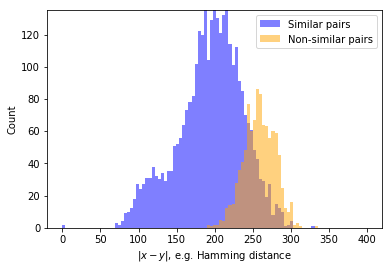

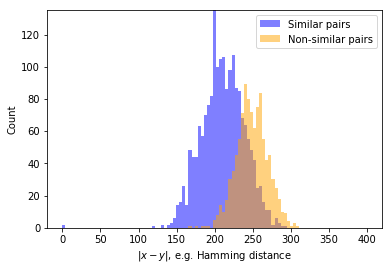

2859/2859 [==============================] - 1s 213us/step
2018-03-08 13:49:43,893 - root - DEBUG - [Iteration = 6] Training Loss = 37.171345475820196, Testing Loss = 46.697270947430006
2018-03-08 13:49:43,895 - root - DEBUG - Iteration 7 (current beta = 11.390625)


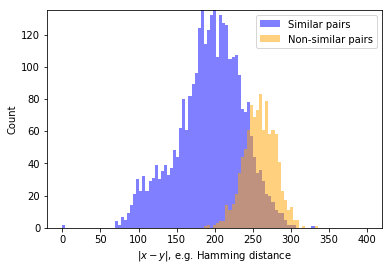

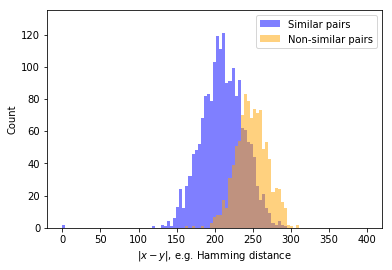

2859/2859 [==============================] - 1s 199us/step
2018-03-08 13:53:33,015 - root - DEBUG - [Iteration = 7] Training Loss = 36.80178813225308, Testing Loss = 47.02099758397036
2018-03-08 13:53:33,016 - root - DEBUG - Iteration 8 (current beta = 17.0859375)


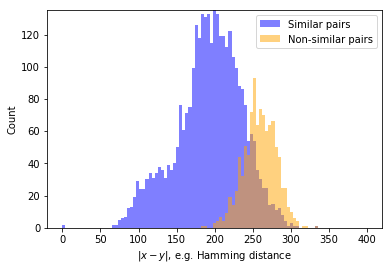

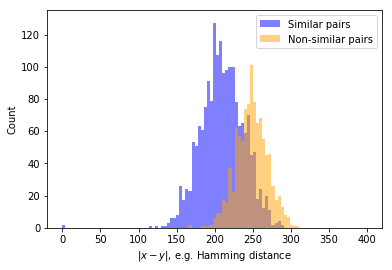

2859/2859 [==============================] - 1s 205us/step
2018-03-08 13:57:20,645 - root - DEBUG - [Iteration = 8] Training Loss = 36.968726622723686, Testing Loss = 47.338649898694506
2018-03-08 13:57:20,647 - root - DEBUG - Iteration 9 (current beta = 25.62890625)


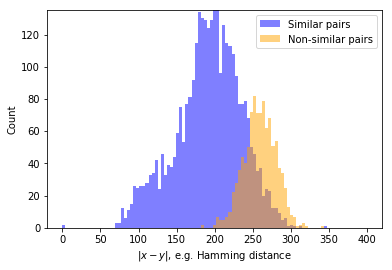

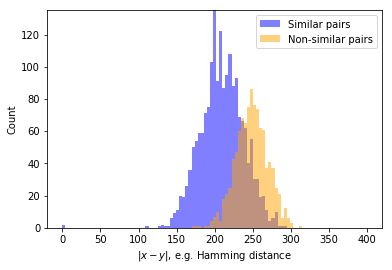

2859/2859 [==============================] - 1s 208us/step
2018-03-08 14:01:07,807 - root - DEBUG - [Iteration = 9] Training Loss = 36.91650842782088, Testing Loss = 47.66929551945486
2018-03-08 14:01:07,808 - root - DEBUG - Iteration 10 (current beta = 38.443359375)


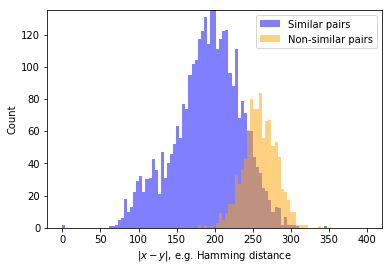

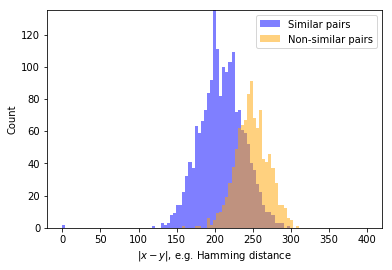

2859/2859 [==============================] - 1s 209us/step
2018-03-08 14:04:57,636 - root - DEBUG - [Iteration = 10] Training Loss = 37.191451889764124, Testing Loss = 48.34985108507309
2018-03-08 14:04:57,638 - root - DEBUG - Iteration 11 (current beta = 57.6650390625)


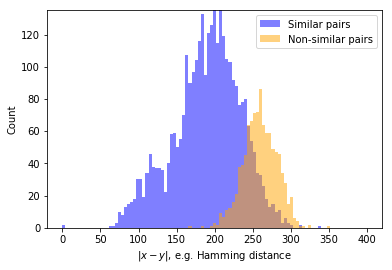

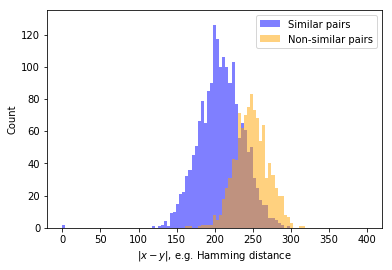

2859/2859 [==============================] - 1s 209us/step
2018-03-08 14:08:46,929 - root - DEBUG - [Iteration = 11] Training Loss = 37.361021047795234, Testing Loss = 49.27029699060041
2018-03-08 14:08:46,931 - root - DEBUG - Iteration 12 (current beta = 86.49755859375)


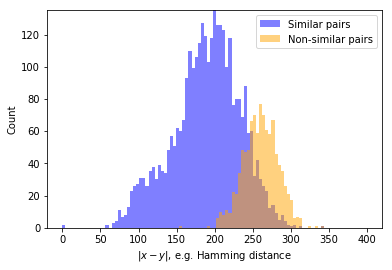

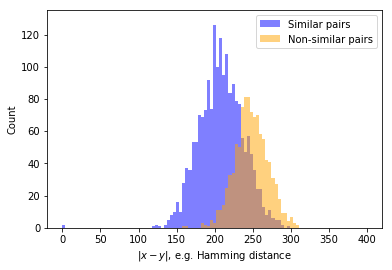

2859/2859 [==============================] - 1s 219us/step
2018-03-08 14:12:34,471 - root - DEBUG - [Iteration = 12] Training Loss = 37.10603098374969, Testing Loss = 49.605117222778276
2018-03-08 14:12:34,473 - root - DEBUG - Iteration 13 (current beta = 129.746337890625)


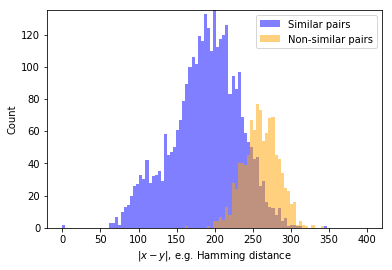

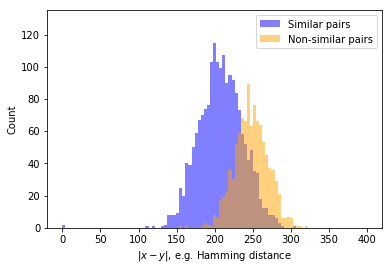

2859/2859 [==============================] - 1s 202us/step
2018-03-08 14:16:19,732 - root - DEBUG - [Iteration = 13] Training Loss = 37.05274533632776, Testing Loss = 49.84857452945636
2018-03-08 14:16:19,733 - root - DEBUG - Iteration 14 (current beta = 194.6195068359375)


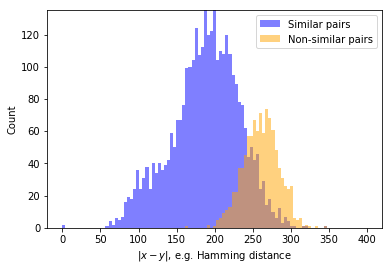

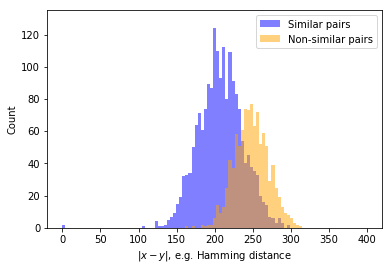

2859/2859 [==============================] - 1s 208us/step
2018-03-08 14:20:05,825 - root - DEBUG - [Iteration = 14] Training Loss = 37.10592331847183, Testing Loss = 49.84840506196397
2018-03-08 14:20:05,827 - root - DEBUG - Iteration 15 (current beta = 291.92926025390625)


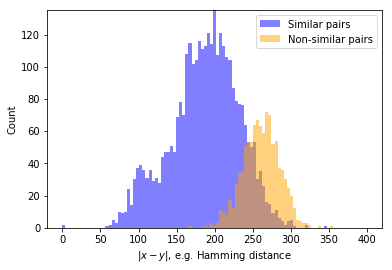

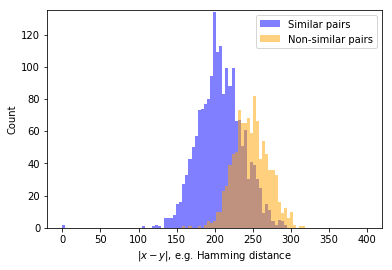

2859/2859 [==============================] - 1s 190us/step
2018-03-08 14:23:48,609 - root - DEBUG - [Iteration = 15] Training Loss = 37.44179768286907, Testing Loss = 50.76522488542352
2018-03-08 14:23:48,611 - root - DEBUG - Iteration 16 (current beta = 437.8938903808594)


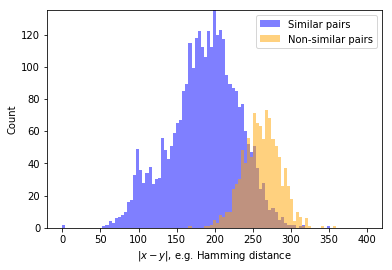

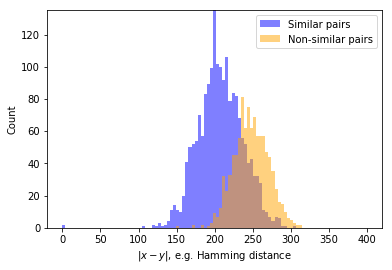

2859/2859 [==============================] - 1s 193us/step
2018-03-08 14:27:32,157 - root - DEBUG - [Iteration = 16] Training Loss = 37.32909878323561, Testing Loss = 50.86036934624105
2018-03-08 14:27:32,158 - root - DEBUG - Iteration 17 (current beta = 656.8408355712891)


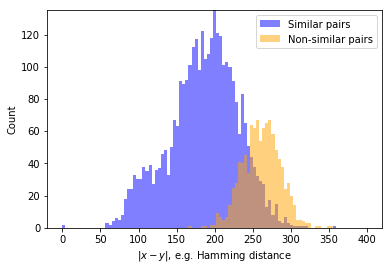

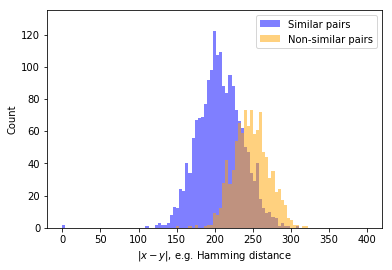

2859/2859 [==============================] - 1s 194us/step
2018-03-08 14:31:14,086 - root - DEBUG - [Iteration = 17] Training Loss = 37.630200455717855, Testing Loss = 51.79678445814706
2018-03-08 14:31:14,087 - root - DEBUG - Iteration 18 (current beta = 985.2612533569336)


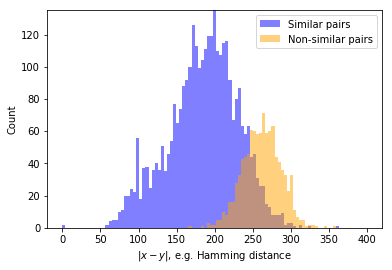

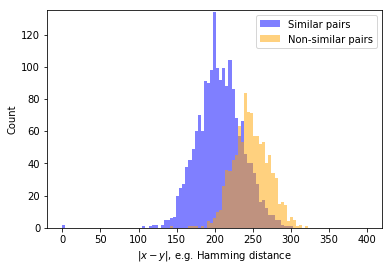

2859/2859 [==============================] - 1s 197us/step
2018-03-08 14:34:59,037 - root - DEBUG - [Iteration = 18] Training Loss = 37.62125769295528, Testing Loss = 52.36592251456422
2018-03-08 14:34:59,038 - root - DEBUG - Iteration 19 (current beta = 1477.8918800354004)


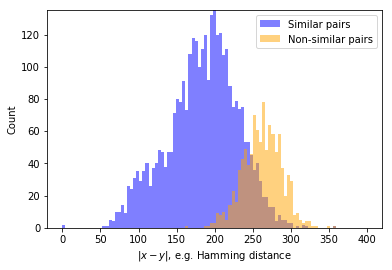

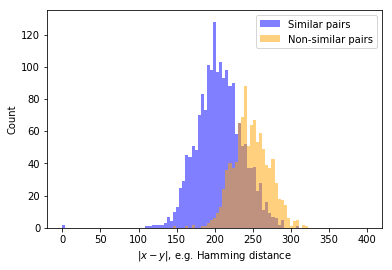

2859/2859 [==============================] - 1s 185us/step
2018-03-08 14:38:43,563 - root - DEBUG - [Iteration = 19] Training Loss = 37.67636156348032, Testing Loss = 52.66038651581451
2018-03-08 14:38:43,565 - root - DEBUG - Iteration 20 (current beta = 2216.8378200531006)


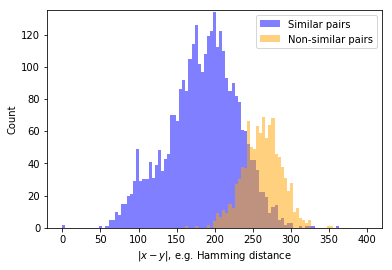

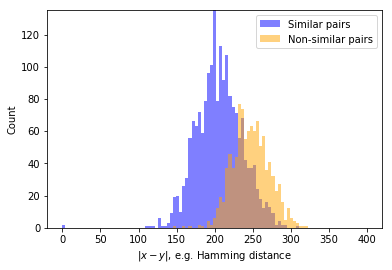

2859/2859 [==============================] - 1s 190us/step
2018-03-08 14:42:27,698 - root - DEBUG - [Iteration = 20] Training Loss = 37.37309501913471, Testing Loss = 53.08257289965197
2018-03-08 14:42:27,700 - root - DEBUG - Iteration 21 (current beta = 3325.256730079651)


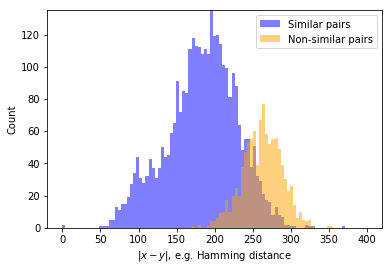

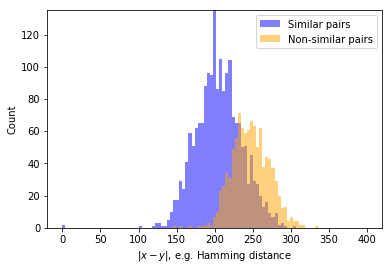

2859/2859 [==============================] - 1s 190us/step
2018-03-08 14:46:10,242 - root - DEBUG - [Iteration = 21] Training Loss = 37.86846602607298, Testing Loss = 53.85845366121381
2018-03-08 14:46:10,243 - root - DEBUG - Iteration 22 (current beta = 4987.885095119476)


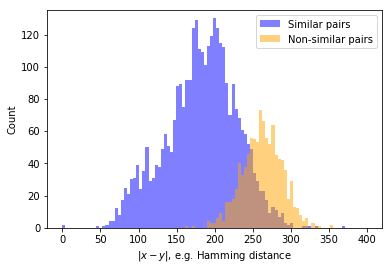

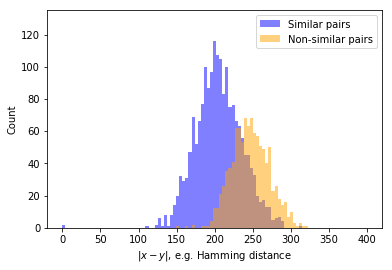

2859/2859 [==============================] - 1s 200us/step
2018-03-08 14:49:54,795 - root - DEBUG - [Iteration = 22] Training Loss = 38.166487664863965, Testing Loss = 54.523099124744334
2018-03-08 14:49:54,797 - root - DEBUG - Iteration 23 (current beta = 7481.8276426792145)


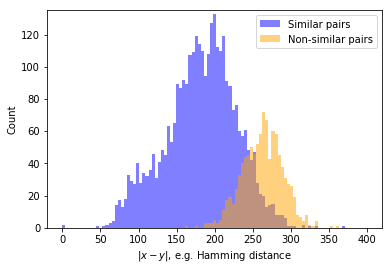

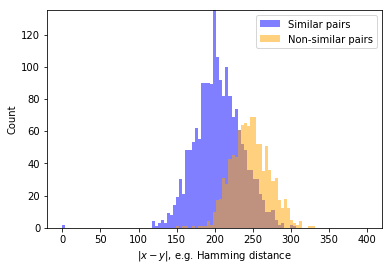

2859/2859 [==============================] - 1s 192us/step
2018-03-08 14:53:39,018 - root - DEBUG - [Iteration = 23] Training Loss = 38.48432030778353, Testing Loss = 55.12456064684569
2018-03-08 14:53:39,019 - root - DEBUG - Iteration 24 (current beta = 11222.741464018822)


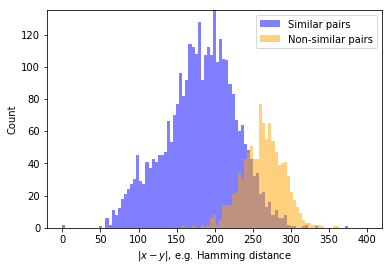

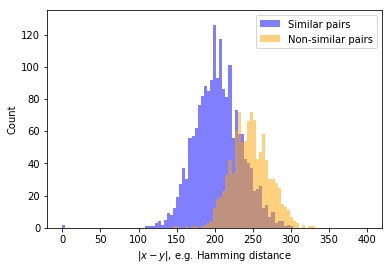

2859/2859 [==============================] - 1s 192us/step
2018-03-08 14:57:23,174 - root - DEBUG - [Iteration = 24] Training Loss = 38.68245222797744, Testing Loss = 55.599619729821605
2018-03-08 14:57:23,176 - root - DEBUG - Iteration 25 (current beta = 16834.112196028233)


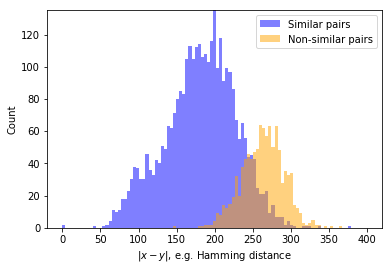

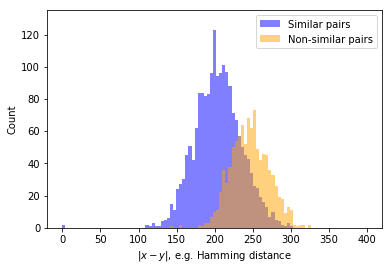

2859/2859 [==============================] - 1s 189us/step
2018-03-08 15:01:06,135 - root - DEBUG - [Iteration = 25] Training Loss = 38.412580919588954, Testing Loss = 55.901212706854395
2018-03-08 15:01:06,137 - root - DEBUG - Iteration 26 (current beta = 25251.16829404235)


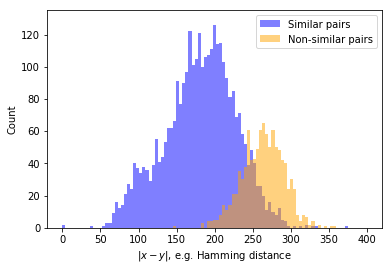

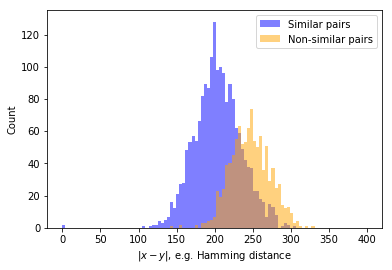

2859/2859 [==============================] - 1s 205us/step
2018-03-08 15:04:50,708 - root - DEBUG - [Iteration = 26] Training Loss = 38.43986064154705, Testing Loss = 56.377495797708676
2018-03-08 15:04:50,710 - root - DEBUG - Iteration 27 (current beta = 37876.75244106352)


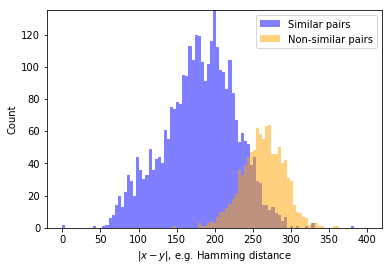

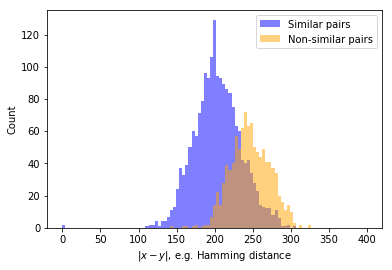

2859/2859 [==============================] - 1s 202us/step
2018-03-08 15:08:34,752 - root - DEBUG - [Iteration = 27] Training Loss = 38.34793389195667, Testing Loss = 56.535959250612585
2018-03-08 15:08:34,753 - root - DEBUG - Iteration 28 (current beta = 56815.128661595285)


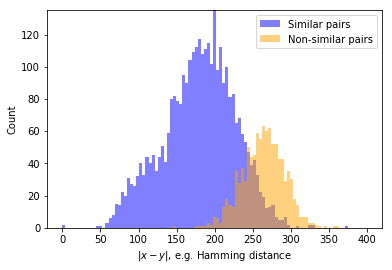

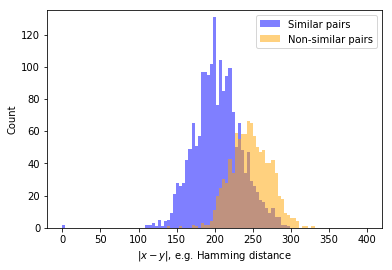

2859/2859 [==============================] - 1s 205us/step
2018-03-08 15:12:19,188 - root - DEBUG - [Iteration = 28] Training Loss = 37.83622357001537, Testing Loss = 56.23691966517816
2018-03-08 15:12:19,190 - root - DEBUG - Iteration 29 (current beta = 85222.69299239293)


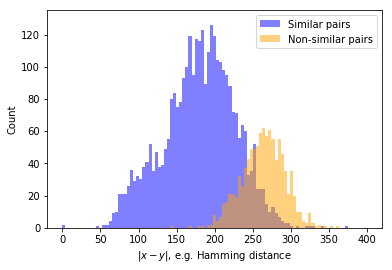

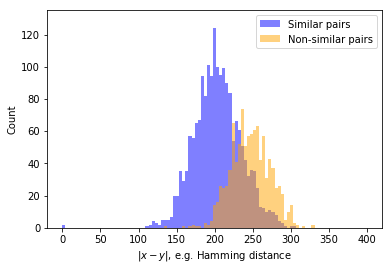

2859/2859 [==============================] - 1s 202us/step
2018-03-08 15:16:01,316 - root - DEBUG - [Iteration = 29] Training Loss = 38.07583159121738, Testing Loss = 56.3943650079549
2018-03-08 15:16:01,318 - root - DEBUG - Iteration 30 (current beta = 127834.03948858939)


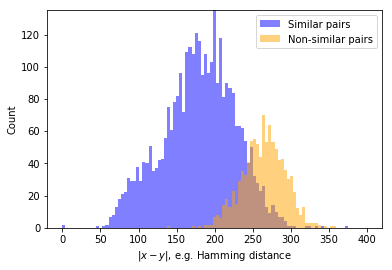

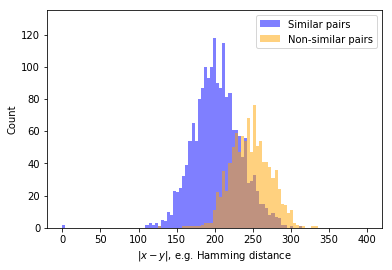

2859/2859 [==============================] - 1s 202us/step
2018-03-08 15:19:45,636 - root - DEBUG - [Iteration = 30] Training Loss = 38.14073814399337, Testing Loss = 56.79943839483805
2018-03-08 15:19:45,638 - root - DEBUG - Iteration 31 (current beta = 191751.0592328841)


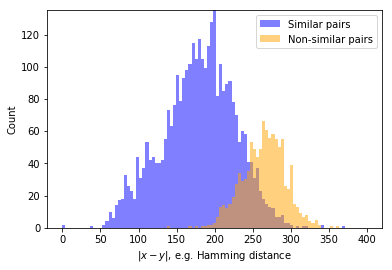

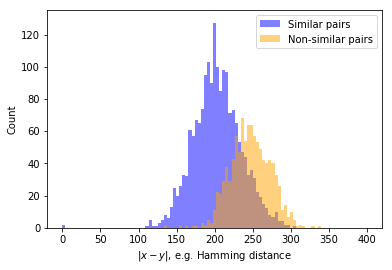

2859/2859 [==============================] - 1s 199us/step
2018-03-08 15:23:29,594 - root - DEBUG - [Iteration = 31] Training Loss = 37.69380278791991, Testing Loss = 56.61306384994918
2018-03-08 15:23:29,595 - root - DEBUG - Iteration 32 (current beta = 287626.58884932613)


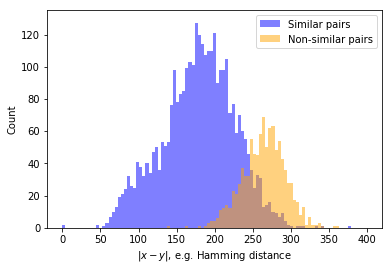

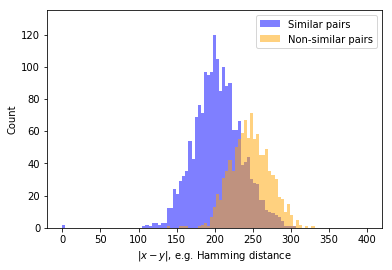

2859/2859 [==============================] - 1s 215us/step
2018-03-08 15:27:14,508 - root - DEBUG - [Iteration = 32] Training Loss = 37.46265180476633, Testing Loss = 56.81167404582426
2018-03-08 15:27:14,509 - root - DEBUG - Iteration 33 (current beta = 431439.8832739892)


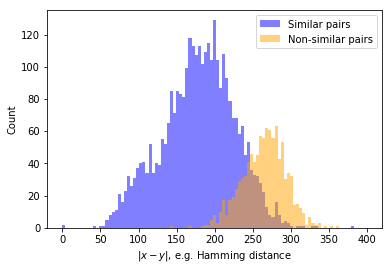

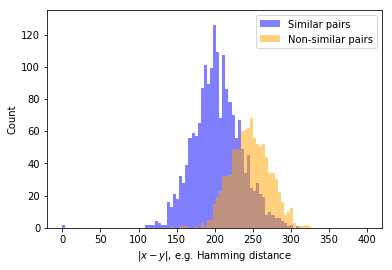

2859/2859 [==============================] - 1s 197us/step
2018-03-08 15:30:56,390 - root - DEBUG - [Iteration = 33] Training Loss = 37.40997273536698, Testing Loss = 57.41970957605603
2018-03-08 15:30:56,392 - root - DEBUG - Iteration 34 (current beta = 647159.8249109838)


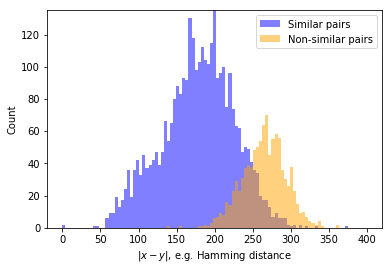

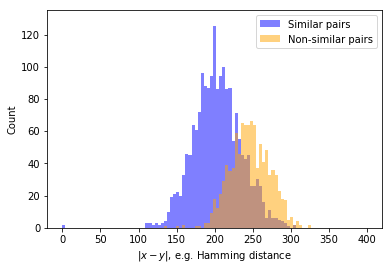

2859/2859 [==============================] - 1s 200us/step
2018-03-08 15:34:41,051 - root - DEBUG - [Iteration = 34] Training Loss = 37.15059916571166, Testing Loss = 57.15796845056828
2018-03-08 15:34:41,052 - root - DEBUG - Iteration 35 (current beta = 970739.7373664756)


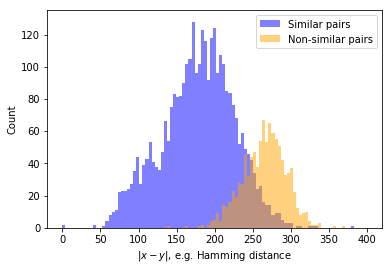

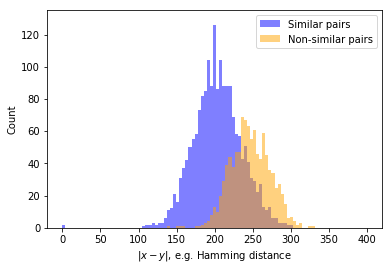

2859/2859 [==============================] - 1s 205us/step
2018-03-08 15:38:24,831 - root - DEBUG - [Iteration = 35] Training Loss = 36.547885711585536, Testing Loss = 56.680840126239744
2018-03-08 15:38:24,832 - root - DEBUG - Iteration 36 (current beta = 1456109.6060497134)


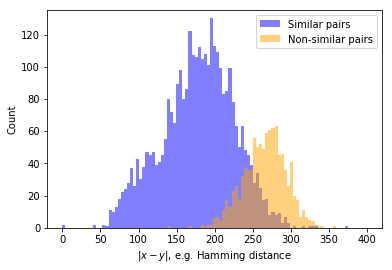

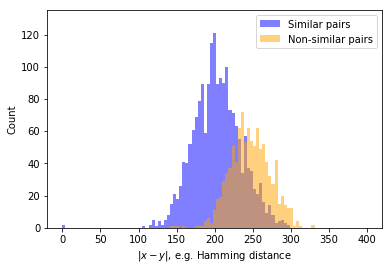

2859/2859 [==============================] - 1s 181us/step
2018-03-08 15:42:02,086 - root - DEBUG - [Iteration = 36] Training Loss = 36.193020932834465, Testing Loss = 56.92584895779095
2018-03-08 15:42:02,087 - root - DEBUG - Iteration 37 (current beta = 2184164.40907457)


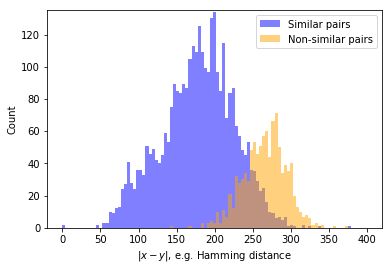

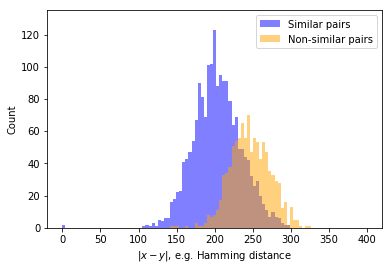

2859/2859 [==============================] - 1s 222us/step
2018-03-08 15:45:34,250 - root - DEBUG - [Iteration = 37] Training Loss = 35.98487622140787, Testing Loss = 57.17413968604609
2018-03-08 15:45:34,252 - root - DEBUG - Iteration 38 (current beta = 3276246.613611855)


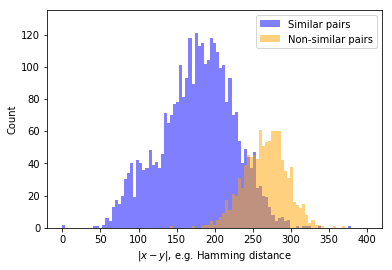

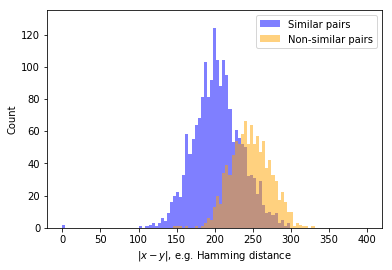

2859/2859 [==============================] - 1s 183us/step
2018-03-08 15:49:15,048 - root - DEBUG - [Iteration = 38] Training Loss = 35.67639425363399, Testing Loss = 57.0976868858284
2018-03-08 15:49:15,050 - root - DEBUG - Iteration 39 (current beta = 4914369.920417783)


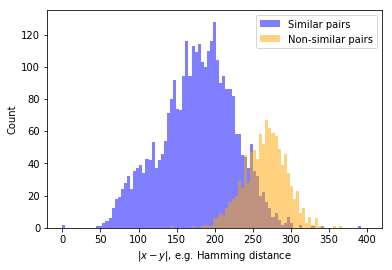

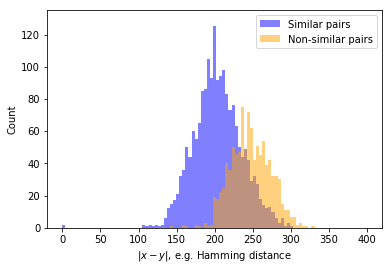

2859/2859 [==============================] - 1s 180us/step
2018-03-08 15:52:53,771 - root - DEBUG - [Iteration = 39] Training Loss = 35.47121657875026, Testing Loss = 56.881560395838875
2018-03-08 15:52:53,772 - root - DEBUG - Iteration 40 (current beta = 7371554.880626675)


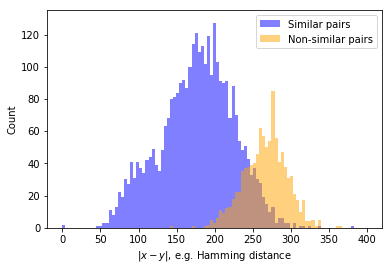

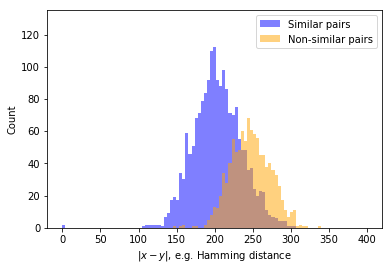

2859/2859 [==============================] - 1s 177us/step
2018-03-08 15:56:34,627 - root - DEBUG - [Iteration = 40] Training Loss = 35.503604506021546, Testing Loss = 56.82590776533879
2018-03-08 15:56:34,629 - root - DEBUG - Iteration 41 (current beta = 11057332.320940012)


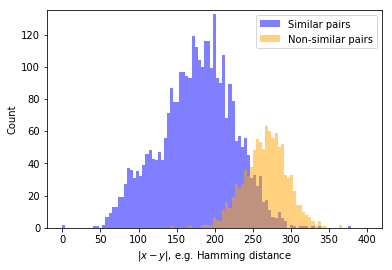

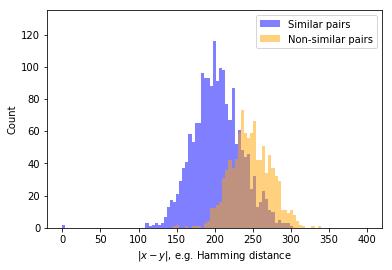

2859/2859 [==============================] - 1s 184us/step
2018-03-08 16:00:16,805 - root - DEBUG - [Iteration = 41] Training Loss = 35.82152022744037, Testing Loss = 57.29230437598974
2018-03-08 16:00:16,807 - root - DEBUG - Iteration 42 (current beta = 16585998.48141002)


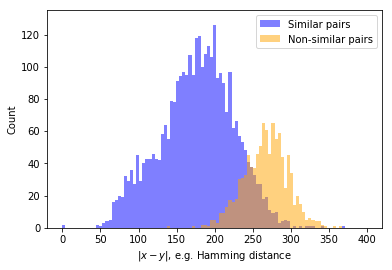

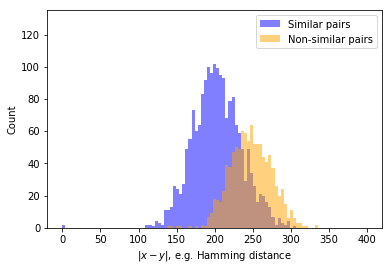

2859/2859 [==============================] - 1s 182us/step
2018-03-08 16:04:00,069 - root - DEBUG - [Iteration = 42] Training Loss = 35.878000503539354, Testing Loss = 57.62457563861261
2018-03-08 16:04:00,070 - root - DEBUG - Iteration 43 (current beta = 24878997.72211503)


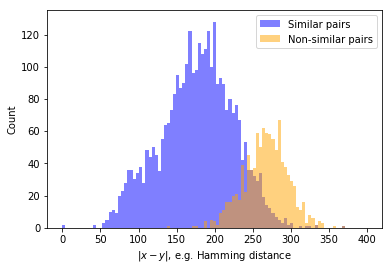

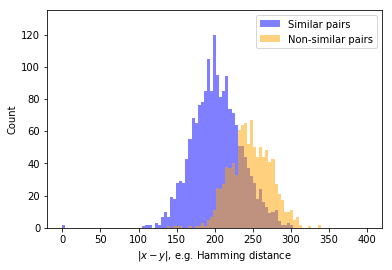

2859/2859 [==============================] - 1s 189us/step
2018-03-08 16:07:41,417 - root - DEBUG - [Iteration = 43] Training Loss = 35.58203281504242, Testing Loss = 57.44334084097844
2018-03-08 16:07:41,418 - root - DEBUG - Iteration 44 (current beta = 37318496.583172545)


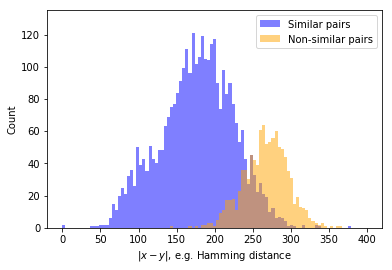

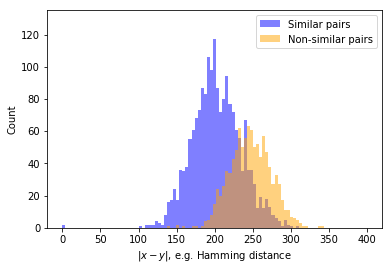

2859/2859 [==============================] - 1s 183us/step
2018-03-08 16:11:22,004 - root - DEBUG - [Iteration = 44] Training Loss = 35.90688531391797, Testing Loss = 57.95677388485765
2018-03-08 16:11:22,006 - root - DEBUG - Iteration 45 (current beta = 55977744.87475882)


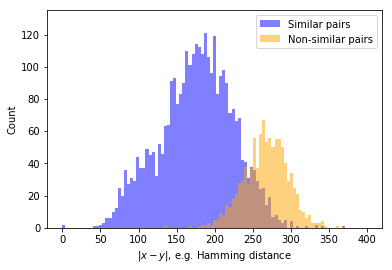

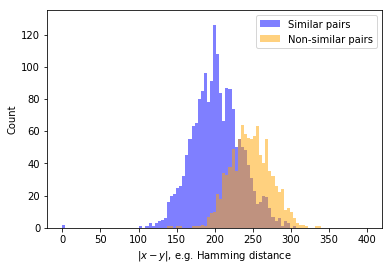

2859/2859 [==============================] - 1s 179us/step
2018-03-08 16:15:03,716 - root - DEBUG - [Iteration = 45] Training Loss = 35.64044060381927, Testing Loss = 57.73891137571091
2018-03-08 16:15:03,717 - root - DEBUG - Iteration 46 (current beta = 83966617.31213823)


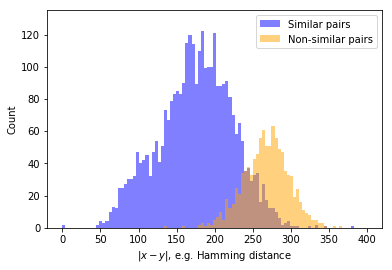

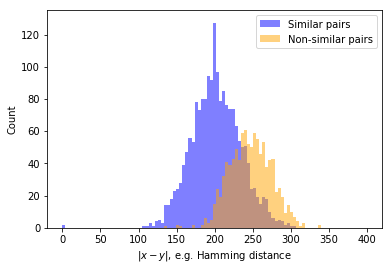

2859/2859 [==============================] - 1s 185us/step
2018-03-08 16:18:44,337 - root - DEBUG - [Iteration = 46] Training Loss = 36.31328815886989, Testing Loss = 58.77438128148813
2018-03-08 16:18:44,338 - root - DEBUG - Iteration 47 (current beta = 125949925.96820734)


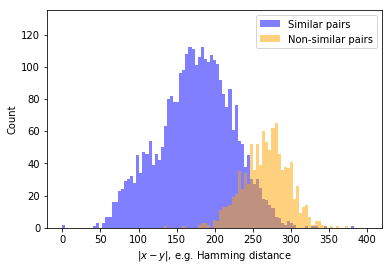

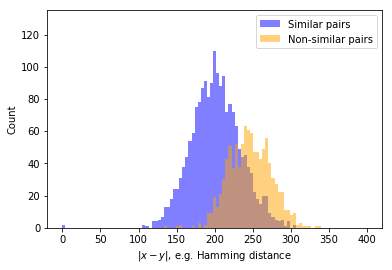

2859/2859 [==============================] - 1s 183us/step
2018-03-08 16:22:26,946 - root - DEBUG - [Iteration = 47] Training Loss = 36.82360323354055, Testing Loss = 59.10095386982131
2018-03-08 16:22:26,947 - root - DEBUG - Iteration 48 (current beta = 188924888.952311)


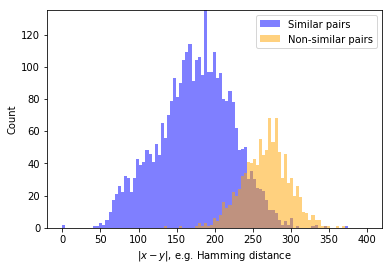

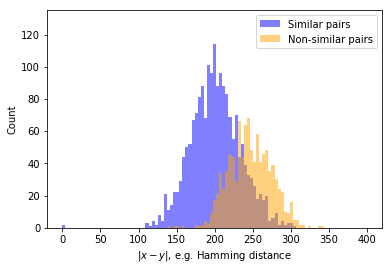

2859/2859 [==============================] - 1s 180us/step
2018-03-08 16:26:08,214 - root - DEBUG - [Iteration = 48] Training Loss = 37.28895450001048, Testing Loss = 59.656836156454816
2018-03-08 16:26:08,215 - root - DEBUG - Iteration 49 (current beta = 283387333.4284665)


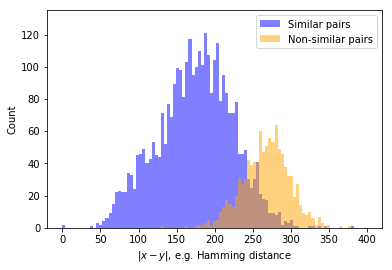

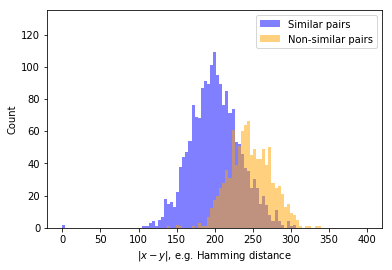

2859/2859 [==============================] - 1s 182us/step
2018-03-08 16:29:48,670 - root - DEBUG - [Iteration = 49] Training Loss = 37.39208447849681, Testing Loss = 59.88056071023918
2018-03-08 16:29:48,671 - root - DEBUG - Iteration 50 (current beta = 425081000.1426997)


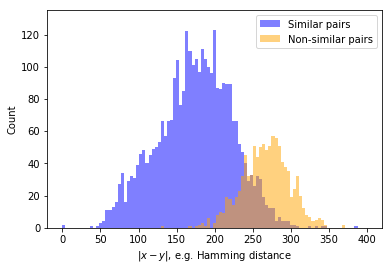

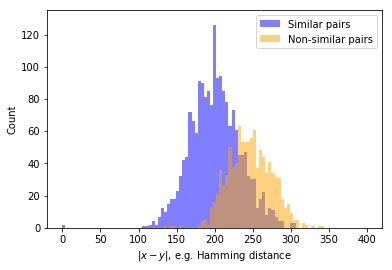

2859/2859 [==============================] - 1s 178us/step
2018-03-08 16:33:30,034 - root - DEBUG - [Iteration = 50] Training Loss = 37.553844419208104, Testing Loss = 60.54478944711395
2018-03-08 16:33:30,036 - root - DEBUG - Iteration 51 (current beta = 637621500.2140496)


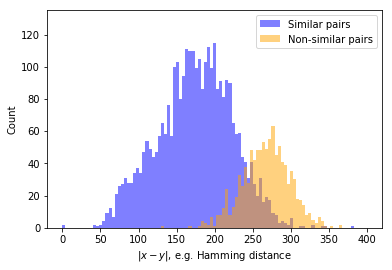

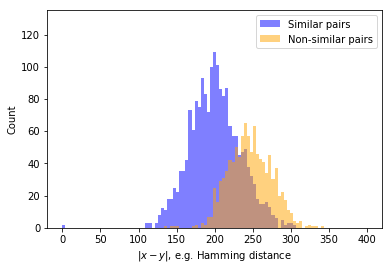

2859/2859 [==============================] - 1s 177us/step
2018-03-08 16:37:11,558 - root - DEBUG - [Iteration = 51] Training Loss = 37.58689944129389, Testing Loss = 60.784169841538194
2018-03-08 16:37:11,559 - root - DEBUG - Iteration 52 (current beta = 956432250.3210744)


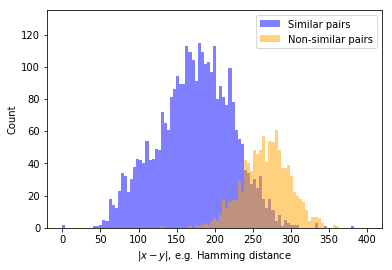

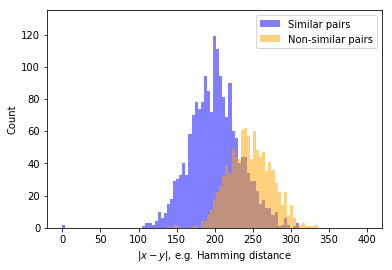

2859/2859 [==============================] - 1s 179us/step
2018-03-08 16:40:51,471 - root - DEBUG - [Iteration = 52] Training Loss = 37.29190083811223, Testing Loss = 60.87585555685696
2018-03-08 16:40:51,473 - root - DEBUG - Iteration 53 (current beta = 1434648375.4816115)


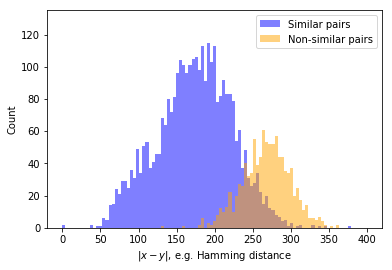

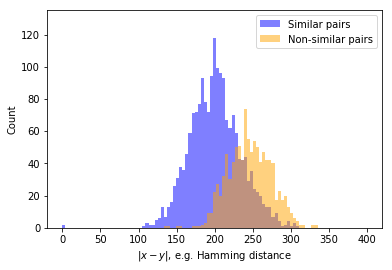

2859/2859 [==============================] - 1s 185us/step
2018-03-08 16:44:29,323 - root - DEBUG - [Iteration = 53] Training Loss = 37.47763429531454, Testing Loss = 61.20190704656923
2018-03-08 16:44:29,325 - root - DEBUG - Iteration 54 (current beta = 2151972563.2224174)


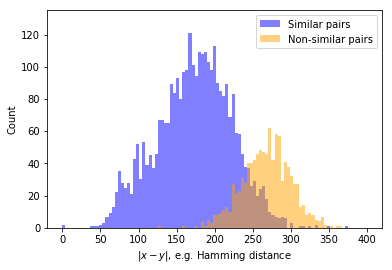

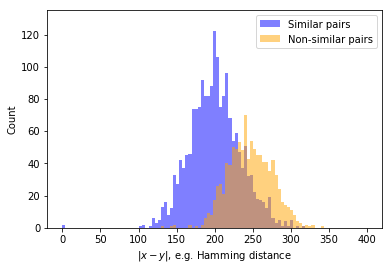

2859/2859 [==============================] - 0s 151us/step
2018-03-08 16:48:01,063 - root - DEBUG - [Iteration = 54] Training Loss = 37.60248955785841, Testing Loss = 61.34631121437964
2018-03-08 16:48:01,064 - root - DEBUG - Iteration 55 (current beta = 3227958844.833626)


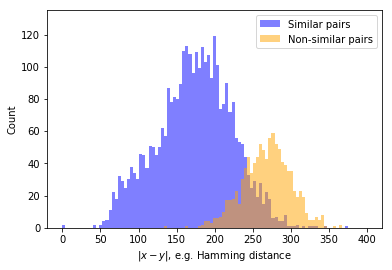

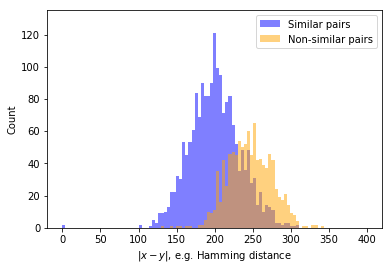

2859/2859 [==============================] - 0s 157us/step
2018-03-08 16:51:07,163 - root - DEBUG - [Iteration = 55] Training Loss = 37.20016316845371, Testing Loss = 61.44984575483756
2018-03-08 16:51:07,164 - root - DEBUG - Iteration 56 (current beta = 4841938267.250439)


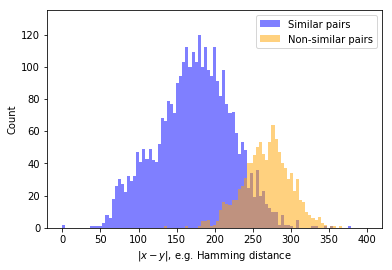

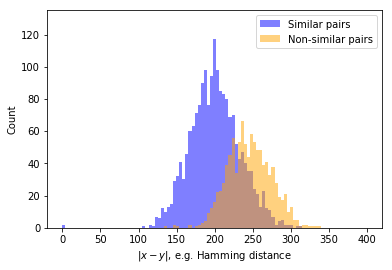

2859/2859 [==============================] - 0s 153us/step
2018-03-08 16:54:09,784 - root - DEBUG - [Iteration = 56] Training Loss = 36.99383450403602, Testing Loss = 61.748024432131274
2018-03-08 16:54:09,785 - root - DEBUG - Iteration 57 (current beta = 7262907400.875658)


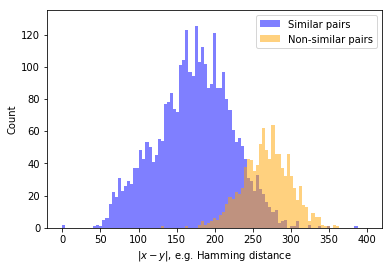

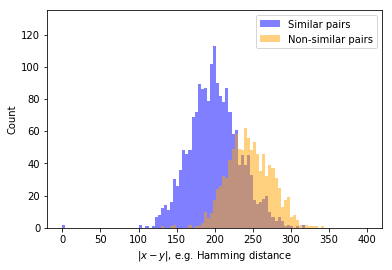

2859/2859 [==============================] - 0s 158us/step
2018-03-08 16:57:11,235 - root - DEBUG - [Iteration = 57] Training Loss = 37.605846272089096, Testing Loss = 62.68744439985336
2018-03-08 16:57:11,236 - root - DEBUG - Iteration 58 (current beta = 10894361101.313488)


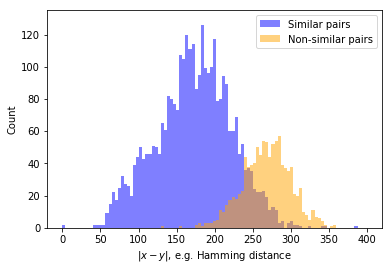

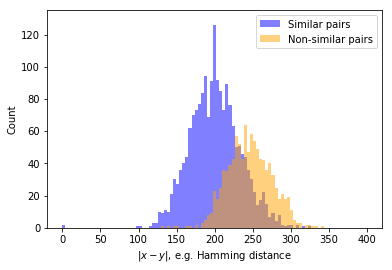

2859/2859 [==============================] - 0s 158us/step
2018-03-08 17:00:14,979 - root - DEBUG - [Iteration = 58] Training Loss = 37.19079118863472, Testing Loss = 62.159870954275384
2018-03-08 17:00:14,980 - root - DEBUG - Iteration 59 (current beta = 16341541651.970232)


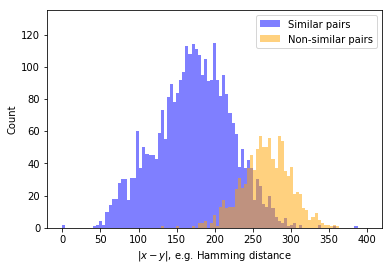

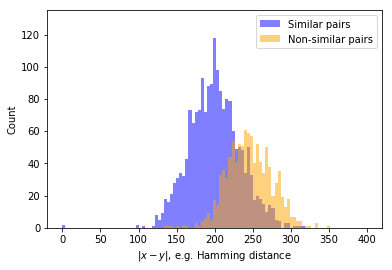

2859/2859 [==============================] - 0s 149us/step
2018-03-08 17:03:18,587 - root - DEBUG - [Iteration = 59] Training Loss = 37.43332185296125, Testing Loss = 62.2039994603064
2018-03-08 17:03:18,588 - root - DEBUG - Iteration 60 (current beta = 24512312477.95535)


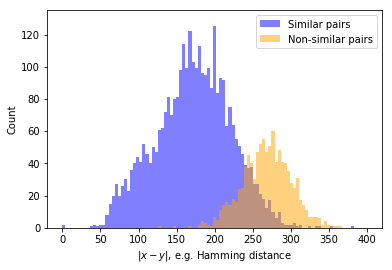

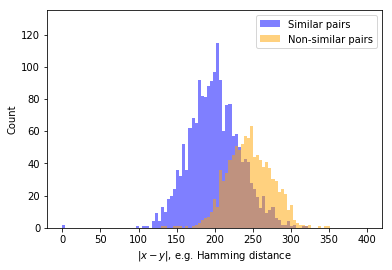

2859/2859 [==============================] - 0s 158us/step
2018-03-08 17:06:21,357 - root - DEBUG - [Iteration = 60] Training Loss = 37.90208619586853, Testing Loss = 62.78373899573253
2018-03-08 17:06:21,358 - root - DEBUG - Iteration 61 (current beta = 36768468716.93302)


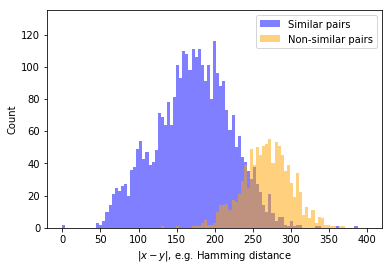

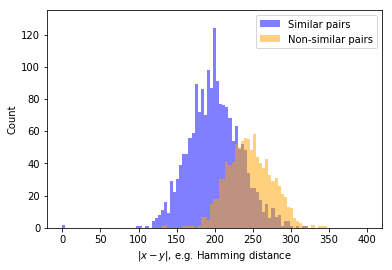

2859/2859 [==============================] - 0s 137us/step
2018-03-08 17:09:26,116 - root - DEBUG - [Iteration = 61] Training Loss = 37.91835981657608, Testing Loss = 63.07001530753019
2018-03-08 17:09:26,117 - root - DEBUG - Iteration 62 (current beta = 55152703075.399536)


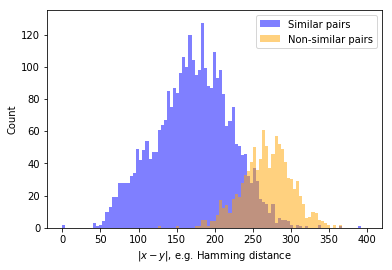

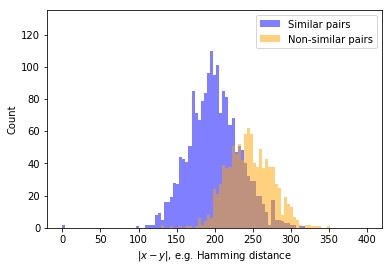

2859/2859 [==============================] - 0s 156us/step
2018-03-08 17:12:30,455 - root - DEBUG - [Iteration = 62] Training Loss = 37.993056073653165, Testing Loss = 63.428850125999624
2018-03-08 17:12:30,456 - root - DEBUG - Iteration 63 (current beta = 82729054613.0993)


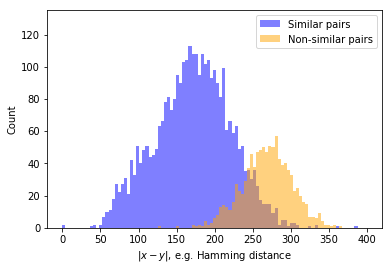

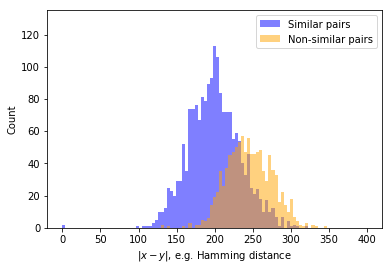

2859/2859 [==============================] - 0s 140us/step
2018-03-08 17:15:35,113 - root - DEBUG - [Iteration = 63] Training Loss = 38.07883685688865, Testing Loss = 63.87636359566031
2018-03-08 17:15:35,114 - root - DEBUG - Iteration 64 (current beta = 124093581919.64896)


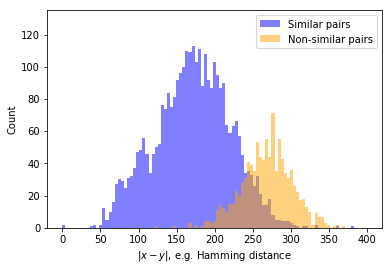

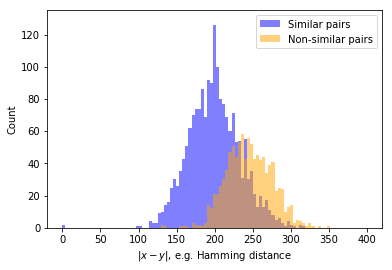

2859/2859 [==============================] - 0s 154us/step
2018-03-08 17:18:38,524 - root - DEBUG - [Iteration = 64] Training Loss = 38.28747347413323, Testing Loss = 63.85726358082462
2018-03-08 17:18:38,525 - root - DEBUG - Iteration 65 (current beta = 186140372879.47345)


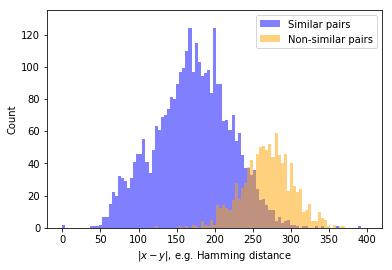

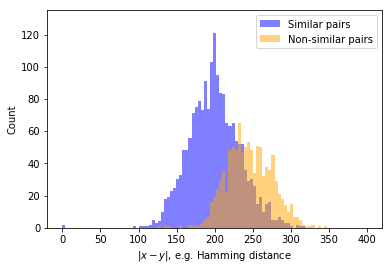

2859/2859 [==============================] - 0s 152us/step
2018-03-08 17:21:42,469 - root - DEBUG - [Iteration = 65] Training Loss = 38.07796281444866, Testing Loss = 63.87140409918922
2018-03-08 17:21:42,470 - root - DEBUG - Iteration 66 (current beta = 279210559319.2102)


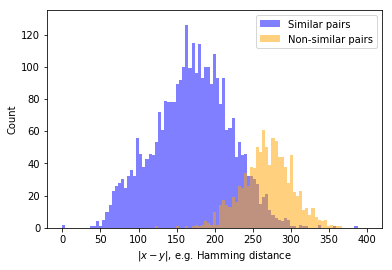

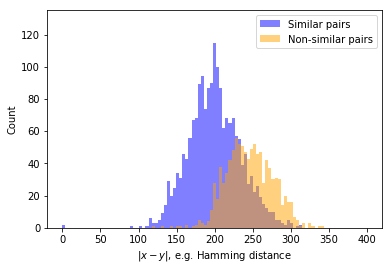

2859/2859 [==============================] - 0s 151us/step
2018-03-08 17:24:46,723 - root - DEBUG - [Iteration = 66] Training Loss = 38.324839550056176, Testing Loss = 64.08112239087116
2018-03-08 17:24:46,724 - root - DEBUG - Iteration 67 (current beta = 418815838978.8153)


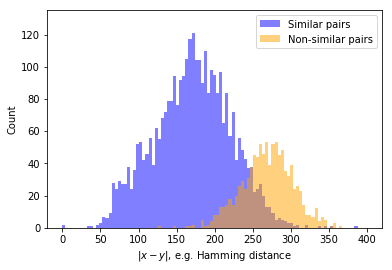

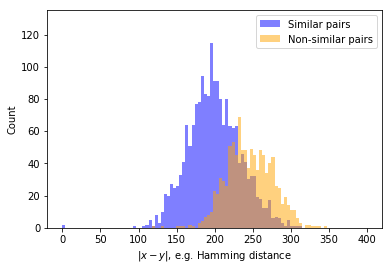

2859/2859 [==============================] - 0s 140us/step
2018-03-08 17:27:51,680 - root - DEBUG - [Iteration = 67] Training Loss = 38.441266568180886, Testing Loss = 64.31905899217972
2018-03-08 17:27:51,681 - root - DEBUG - Iteration 68 (current beta = 628223758468.2229)


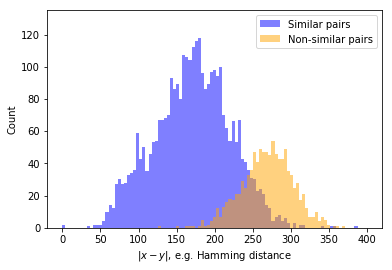

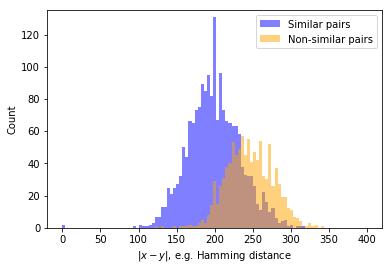

2859/2859 [==============================] - 0s 155us/step
2018-03-08 17:30:56,079 - root - DEBUG - [Iteration = 68] Training Loss = 38.18735748010371, Testing Loss = 64.32633404716739
2018-03-08 17:30:56,080 - root - DEBUG - Iteration 69 (current beta = 942335637702.3344)


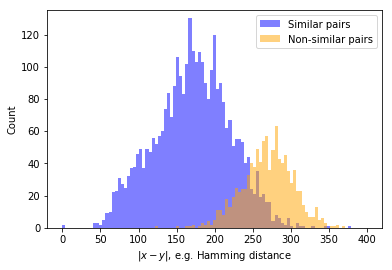

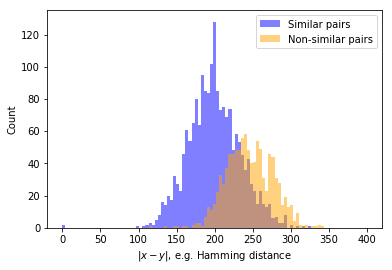

2859/2859 [==============================] - 0s 151us/step
2018-03-08 17:34:00,548 - root - DEBUG - [Iteration = 69] Training Loss = 37.48822437590784, Testing Loss = 64.07380534944605
2018-03-08 17:34:00,549 - root - DEBUG - Iteration 70 (current beta = 1413503456553.5015)


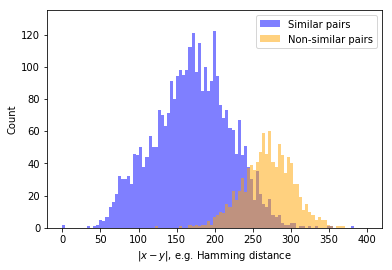

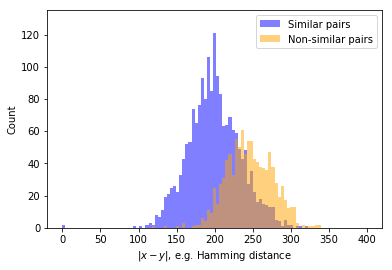

2859/2859 [==============================] - 0s 153us/step
2018-03-08 17:37:05,401 - root - DEBUG - [Iteration = 70] Training Loss = 37.23798259116033, Testing Loss = 63.76529134683319
2018-03-08 17:37:05,402 - root - DEBUG - Iteration 71 (current beta = 2120255184830.2522)


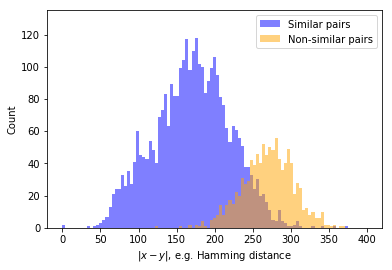

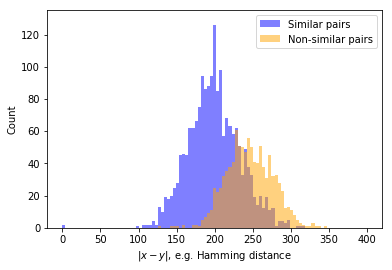

2859/2859 [==============================] - 1s 180us/step
2018-03-08 17:40:10,187 - root - DEBUG - [Iteration = 71] Training Loss = 37.145969426510966, Testing Loss = 63.88735748888438
2018-03-08 17:40:10,189 - root - DEBUG - Iteration 72 (current beta = 3180382777245.3784)


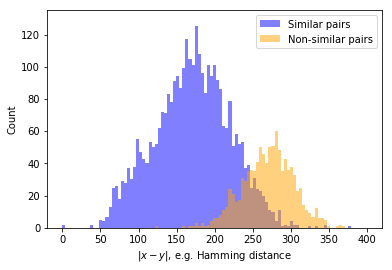

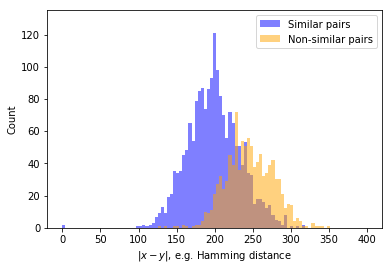

2859/2859 [==============================] - 1s 179us/step
2018-03-08 17:43:47,280 - root - DEBUG - [Iteration = 72] Training Loss = 37.16863574218273, Testing Loss = 64.40157828192562
2018-03-08 17:43:47,282 - root - DEBUG - Iteration 73 (current beta = 4770574165868.067)


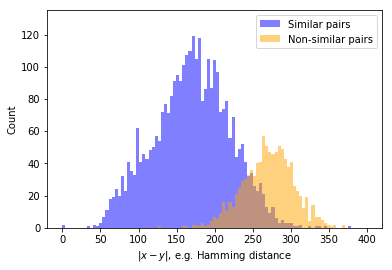

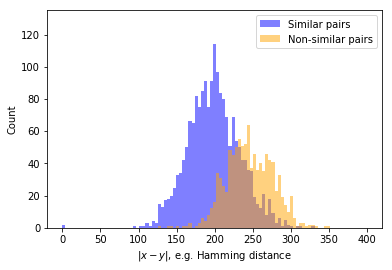

2859/2859 [==============================] - 1s 184us/step
2018-03-08 17:47:24,495 - root - DEBUG - [Iteration = 73] Training Loss = 36.90095165607385, Testing Loss = 64.04183330649302
2018-03-08 17:47:24,497 - root - DEBUG - Iteration 74 (current beta = 7155861248802.102)


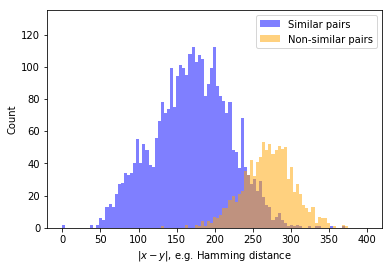

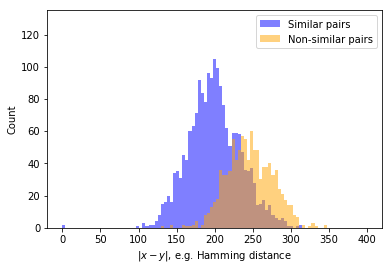

2859/2859 [==============================] - 1s 182us/step
2018-03-08 17:51:02,600 - root - DEBUG - [Iteration = 74] Training Loss = 36.587498743439625, Testing Loss = 63.483992543075416
2018-03-08 17:51:02,601 - root - DEBUG - Iteration 75 (current beta = 10733791873203.152)


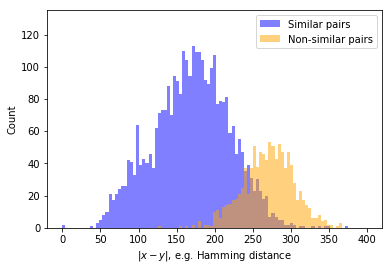

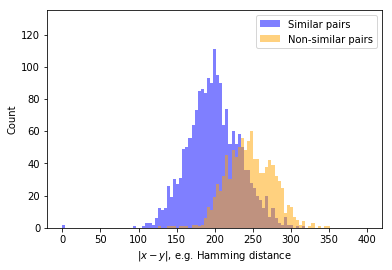

2859/2859 [==============================] - 1s 176us/step
2018-03-08 17:54:39,908 - root - DEBUG - [Iteration = 75] Training Loss = 36.8654372700951, Testing Loss = 63.944965160155725
2018-03-08 17:54:39,909 - root - DEBUG - Iteration 76 (current beta = 16100687809804.729)


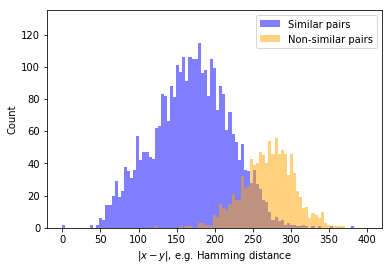

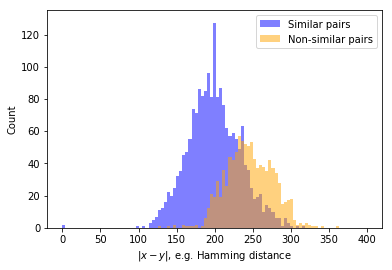

2859/2859 [==============================] - 1s 181us/step
2018-03-08 17:58:17,116 - root - DEBUG - [Iteration = 76] Training Loss = 36.81802753528847, Testing Loss = 64.14663909865077
2018-03-08 17:58:17,118 - root - DEBUG - Iteration 77 (current beta = 24151031714707.094)


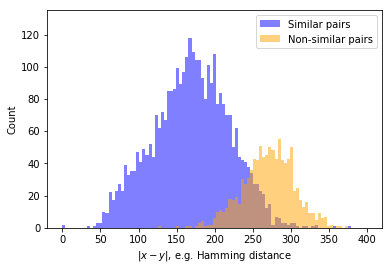

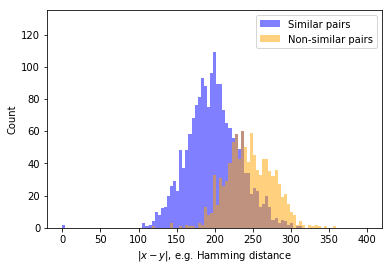

2859/2859 [==============================] - 1s 179us/step
2018-03-08 18:01:53,633 - root - DEBUG - [Iteration = 77] Training Loss = 36.750554706739095, Testing Loss = 64.48442315888514
2018-03-08 18:01:53,635 - root - DEBUG - Iteration 78 (current beta = 36226547572060.64)


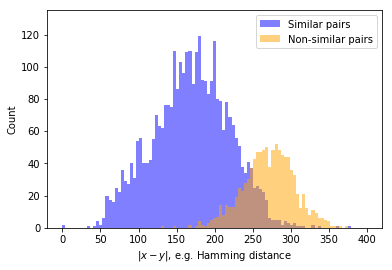

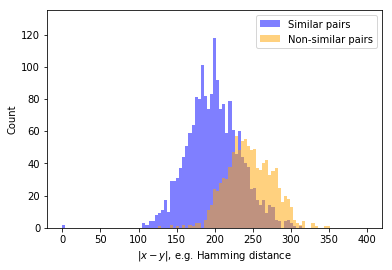

2859/2859 [==============================] - 1s 177us/step
2018-03-08 18:05:30,149 - root - DEBUG - [Iteration = 78] Training Loss = 36.714510796108286, Testing Loss = 64.36661806945494
2018-03-08 18:05:30,151 - root - DEBUG - Iteration 79 (current beta = 54339821358090.96)


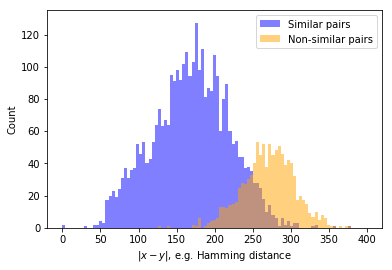

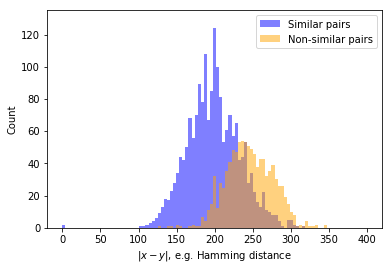

2859/2859 [==============================] - 0s 172us/step
2018-03-08 18:09:07,602 - root - DEBUG - [Iteration = 79] Training Loss = 36.987209552850864, Testing Loss = 64.85263613822286
2018-03-08 18:09:07,603 - root - DEBUG - Iteration 80 (current beta = 81509732037136.44)


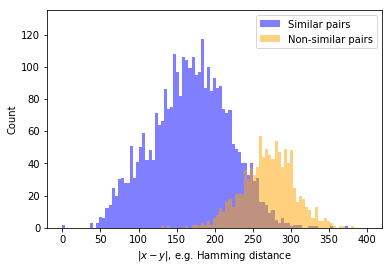

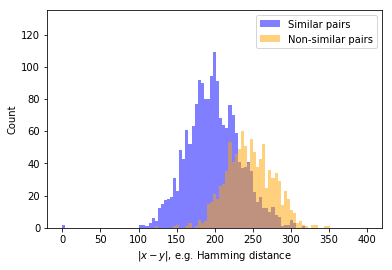

2859/2859 [==============================] - 1s 180us/step
2018-03-08 18:12:45,246 - root - DEBUG - [Iteration = 80] Training Loss = 37.26556039446029, Testing Loss = 64.94733024460739
2018-03-08 18:12:45,247 - root - DEBUG - Iteration 81 (current beta = 122264598055704.66)


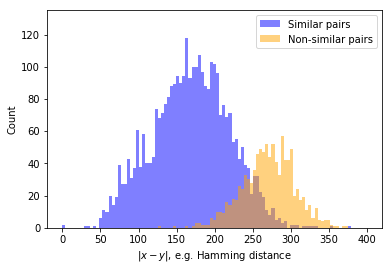

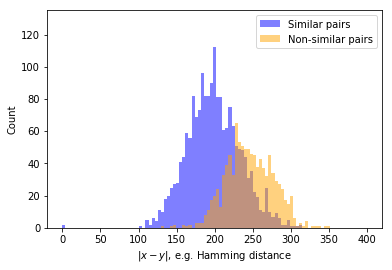

2859/2859 [==============================] - 1s 177us/step
2018-03-08 18:16:23,193 - root - DEBUG - [Iteration = 81] Training Loss = 37.36703562132525, Testing Loss = 65.03860480612748
2018-03-08 18:16:23,194 - root - DEBUG - Iteration 82 (current beta = 183396897083557.0)


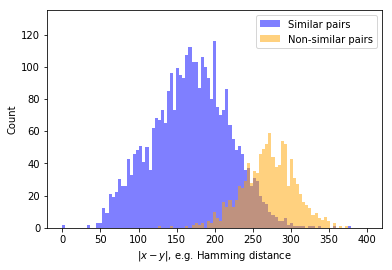

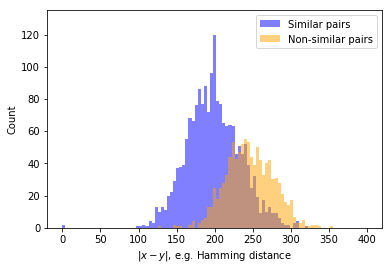

2859/2859 [==============================] - 1s 188us/step
2018-03-08 18:20:01,203 - root - DEBUG - [Iteration = 82] Training Loss = 37.33354439455297, Testing Loss = 64.93096309802299
2018-03-08 18:20:01,204 - root - DEBUG - Iteration 83 (current beta = 275095345625335.5)


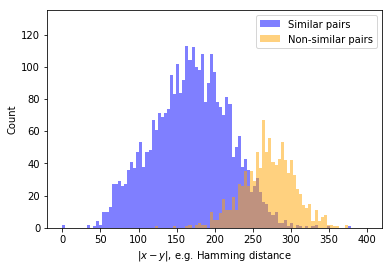

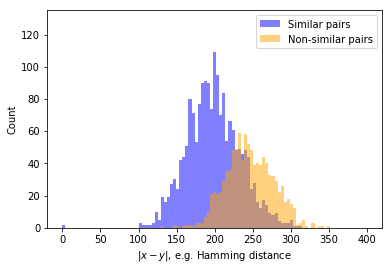

2859/2859 [==============================] - 1s 176us/step
2018-03-08 18:23:38,767 - root - DEBUG - [Iteration = 83] Training Loss = 37.43322618899261, Testing Loss = 65.29448331732482
2018-03-08 18:23:38,768 - root - DEBUG - Iteration 84 (current beta = 412643018438003.25)


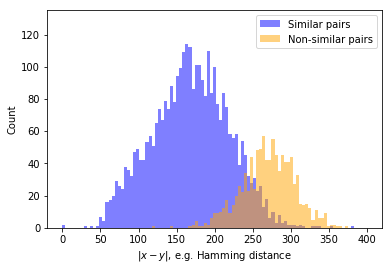

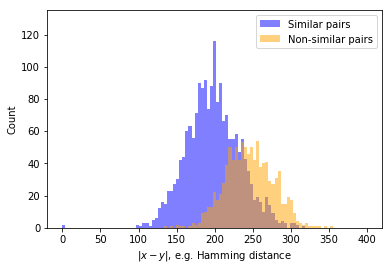

2859/2859 [==============================] - 1s 179us/step
2018-03-08 18:27:15,221 - root - DEBUG - [Iteration = 84] Training Loss = 37.96444218096826, Testing Loss = 65.59476859438624
2018-03-08 18:27:15,223 - root - DEBUG - Iteration 85 (current beta = 618964527657004.9)


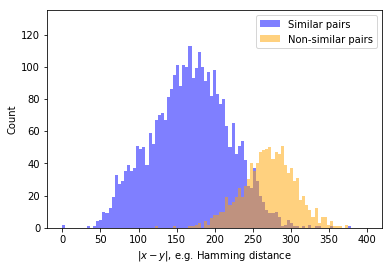

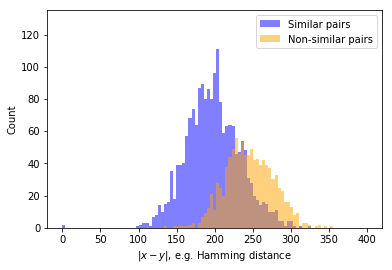

2859/2859 [==============================] - 1s 182us/step
2018-03-08 18:30:52,375 - root - DEBUG - [Iteration = 85] Training Loss = 37.80187128258573, Testing Loss = 65.7932993436702
2018-03-08 18:30:52,376 - root - DEBUG - Iteration 86 (current beta = 928446791485507.2)


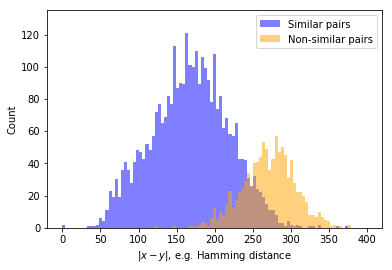

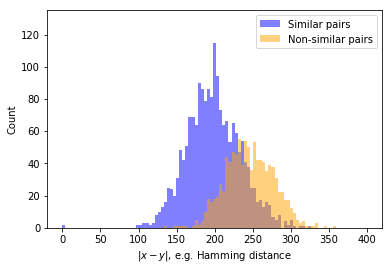

2859/2859 [==============================] - 1s 178us/step
2018-03-08 18:34:29,770 - root - DEBUG - [Iteration = 86] Training Loss = 37.47090495032385, Testing Loss = 65.6963037946667
2018-03-08 18:34:29,771 - root - DEBUG - Iteration 87 (current beta = 1392670187228261.0)


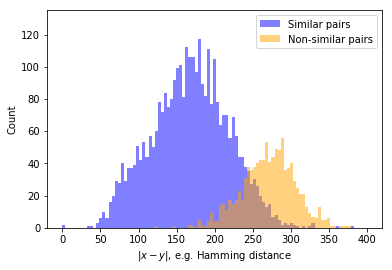

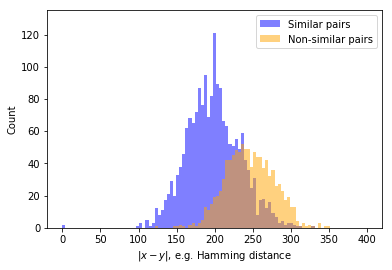

2859/2859 [==============================] - 1s 187us/step
2018-03-08 18:38:06,886 - root - DEBUG - [Iteration = 87] Training Loss = 37.6778370943359, Testing Loss = 65.9209786086034
2018-03-08 18:38:06,888 - root - DEBUG - Iteration 88 (current beta = 2089005280842391.5)


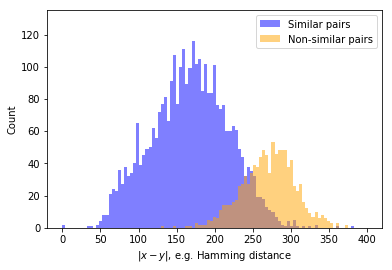

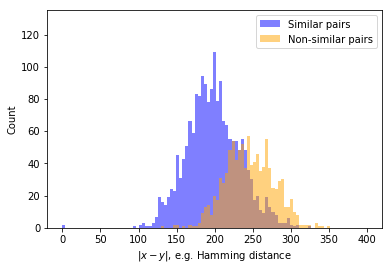

2859/2859 [==============================] - 1s 176us/step
2018-03-08 18:41:44,048 - root - DEBUG - [Iteration = 88] Training Loss = 37.87659867873797, Testing Loss = 65.8998421395146
2018-03-08 18:41:44,049 - root - DEBUG - Iteration 89 (current beta = 3133507921263587.0)


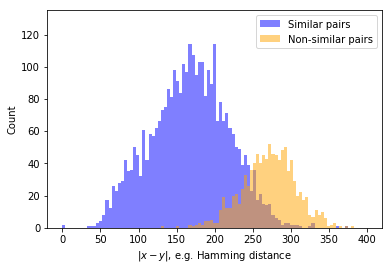

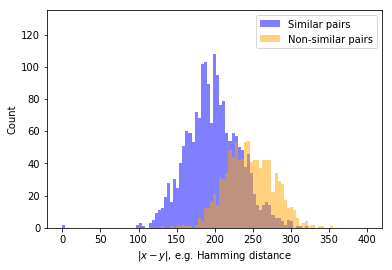

2859/2859 [==============================] - 1s 178us/step
2018-03-08 18:45:21,121 - root - DEBUG - [Iteration = 89] Training Loss = 37.66467102406835, Testing Loss = 66.04505142435072
2018-03-08 18:45:21,122 - root - DEBUG - Iteration 90 (current beta = 4700261881895380.0)


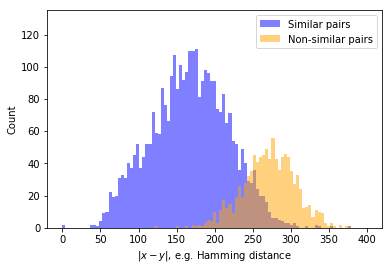

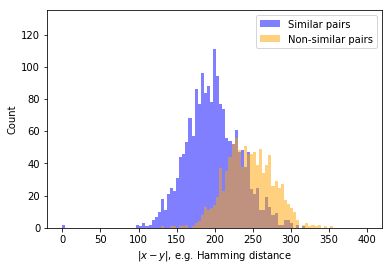

2859/2859 [==============================] - 1s 190us/step
2018-03-08 18:48:58,641 - root - DEBUG - [Iteration = 90] Training Loss = 37.328751618192605, Testing Loss = 66.17262814936416
2018-03-08 18:48:58,642 - root - DEBUG - Iteration 91 (current beta = 7050392822843070.0)


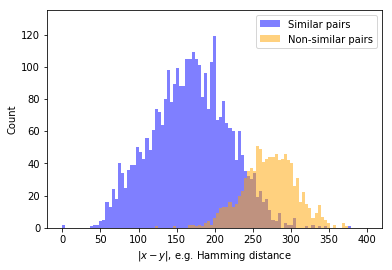

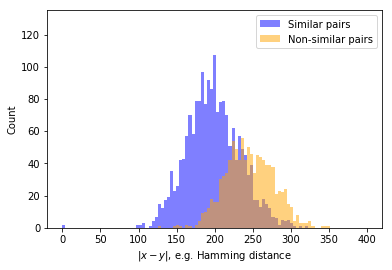

2859/2859 [==============================] - 1s 180us/step
2018-03-08 18:52:35,348 - root - DEBUG - [Iteration = 91] Training Loss = 37.21957459092105, Testing Loss = 66.20981866548678
2018-03-08 18:52:35,349 - root - DEBUG - Iteration 92 (current beta = 1.0575589234264604e+16)


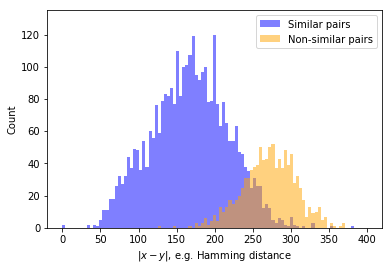

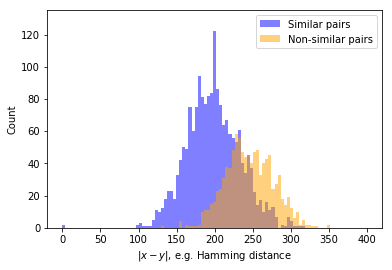

2859/2859 [==============================] - 1s 181us/step
2018-03-08 18:56:13,192 - root - DEBUG - [Iteration = 92] Training Loss = 37.01730741516124, Testing Loss = 66.11260481667126
2018-03-08 18:56:13,193 - root - DEBUG - Iteration 93 (current beta = 1.5863383851396906e+16)


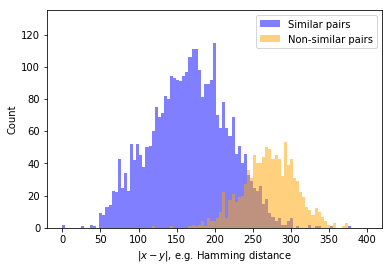

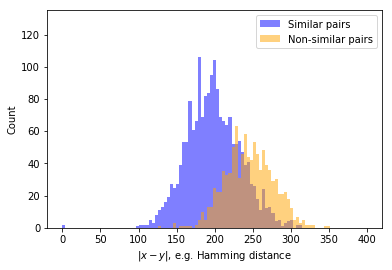

2859/2859 [==============================] - 1s 183us/step
2018-03-08 18:59:50,828 - root - DEBUG - [Iteration = 93] Training Loss = 37.07790552104362, Testing Loss = 66.27859443549136
2018-03-08 18:59:50,829 - root - DEBUG - Iteration 94 (current beta = 2.379507577709536e+16)


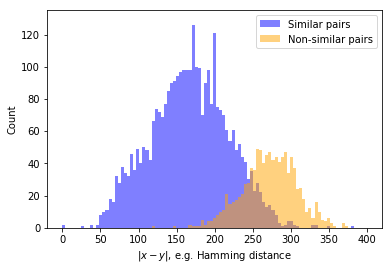

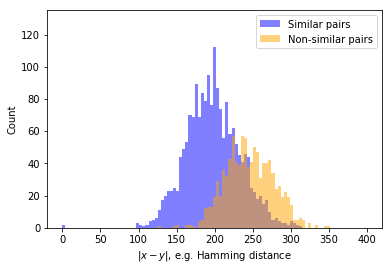

2859/2859 [==============================] - 1s 176us/step
2018-03-08 19:03:28,072 - root - DEBUG - [Iteration = 94] Training Loss = 37.35793820808622, Testing Loss = 66.33283591962604
2018-03-08 19:03:28,073 - root - DEBUG - Iteration 95 (current beta = 3.569261366564304e+16)


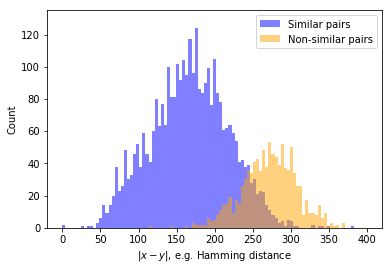

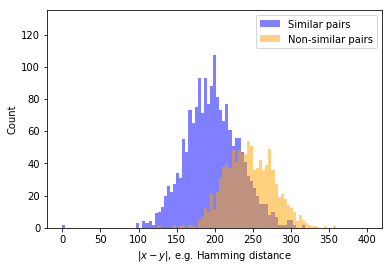

2859/2859 [==============================] - 1s 176us/step
2018-03-08 19:07:04,384 - root - DEBUG - [Iteration = 95] Training Loss = 37.40394079780882, Testing Loss = 66.46447460940769
2018-03-08 19:07:04,385 - root - DEBUG - Iteration 96 (current beta = 5.353892049846456e+16)


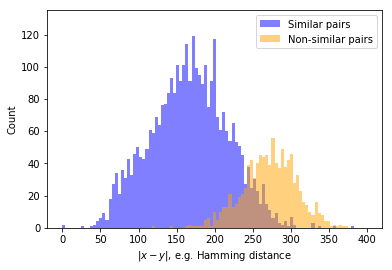

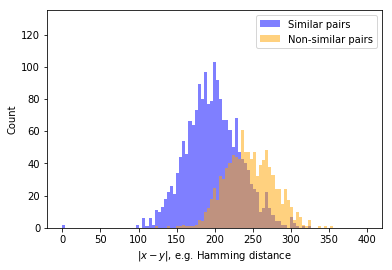

2859/2859 [==============================] - 1s 184us/step
2018-03-08 19:10:41,368 - root - DEBUG - [Iteration = 96] Training Loss = 37.353409442124025, Testing Loss = 66.54280204329302
2018-03-08 19:10:41,369 - root - DEBUG - Iteration 97 (current beta = 8.030838074769683e+16)


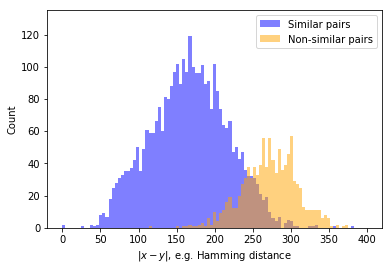

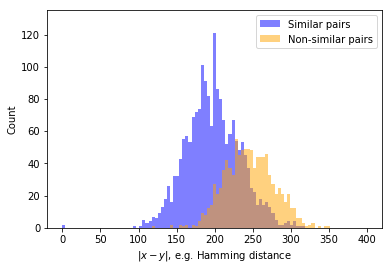

2859/2859 [==============================] - 1s 179us/step
2018-03-08 19:14:17,968 - root - DEBUG - [Iteration = 97] Training Loss = 37.36494932219352, Testing Loss = 66.67405337718618
2018-03-08 19:14:17,969 - root - DEBUG - Iteration 98 (current beta = 1.2046257112154525e+17)


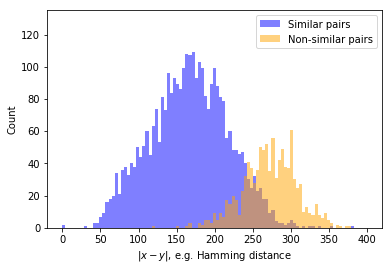

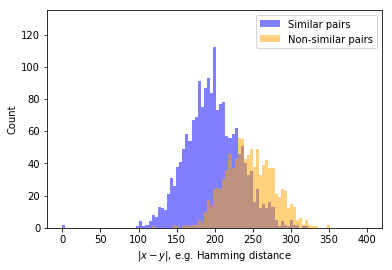

2859/2859 [==============================] - 1s 177us/step
2018-03-08 19:17:54,926 - root - DEBUG - [Iteration = 98] Training Loss = 37.22675558732871, Testing Loss = 66.80674422216732
2018-03-08 19:17:54,927 - root - DEBUG - Iteration 99 (current beta = 1.806938566823179e+17)


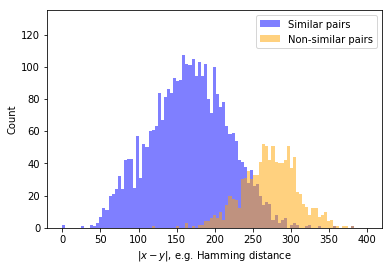

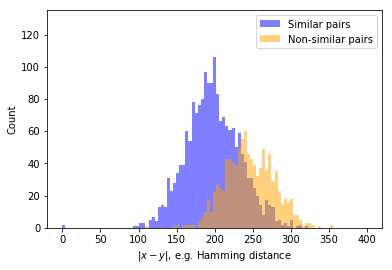

2859/2859 [==============================] - 1s 181us/step
2018-03-08 19:21:32,159 - root - DEBUG - [Iteration = 99] Training Loss = 37.026494933795625, Testing Loss = 66.39507634375387
2018-03-08 19:21:32,160 - root - DEBUG - Iteration 100 (current beta = 2.7104078502347683e+17)


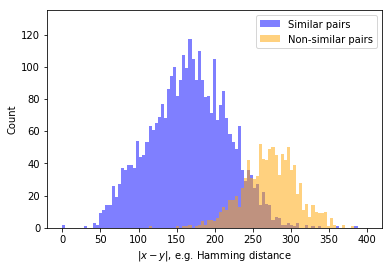

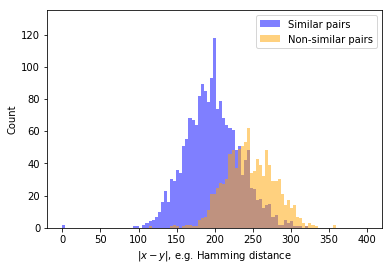

2859/2859 [==============================] - 1s 181us/step
2018-03-08 19:25:09,627 - root - DEBUG - [Iteration = 100] Training Loss = 37.167524304214126, Testing Loss = 66.49398121770423


In [35]:
train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(0, train_loss, test_loss))
train_losses.append(train_loss)
test_losses.append(test_loss)

for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)
#     visualizeFilters()
    
    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

ValueError: x and y must have same first dimension, but have shapes (102,) and (101,)

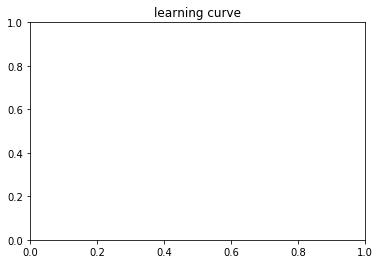

In [36]:
plt.figure()
plt.title("learning curve")
plt.plot(range(0,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(0,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

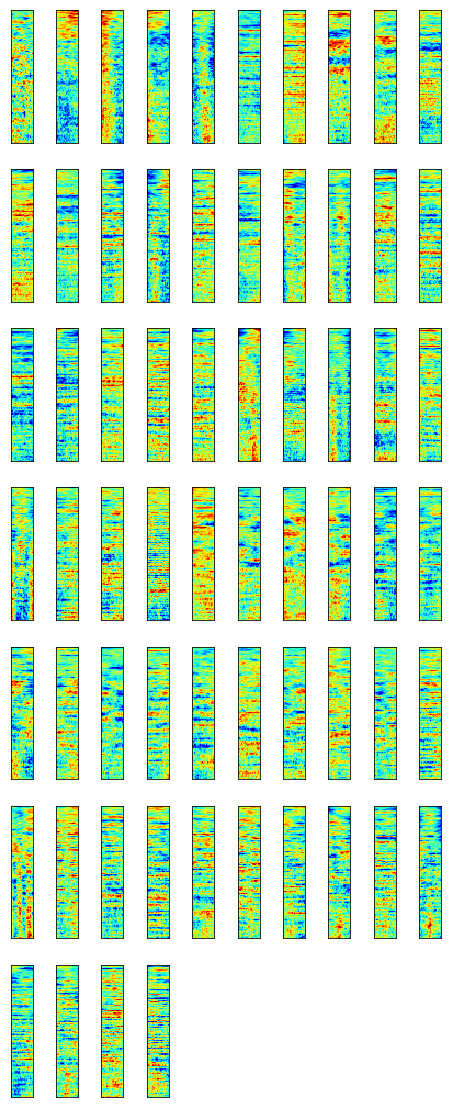

In [37]:
visualizeFilters()

## Save Model

In [38]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-03-08 19:25:14,560 - root - DEBUG - Save model to 2018-03-08[HashNet-100-iteration-dropout-delta-notrain][Iteration=100].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [39]:
representation_model = Model(image_a, encoded_a)

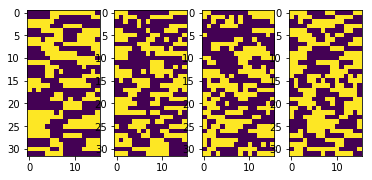

In [40]:
# Get sample output
# Reshaped to be (32,16) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,16) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,16) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,16) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,16) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

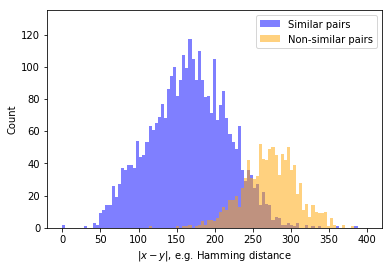

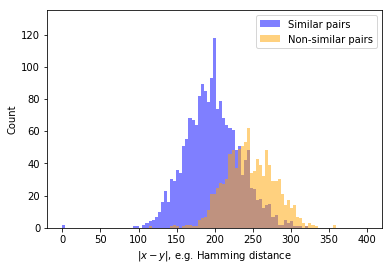

In [41]:
representation_model = Model(image_a, encoded_a)
visualize(X1, X2, groundTruth, representation_model)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 8, 1)     175360      image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 512)          0           sequential_1[1][0]               
__________

In [43]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 12, 1)         154880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 12, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 8, 1)          20480     
Total params: 175,360
Trainable params: 154,880
Non-trainable params: 20,480
_________________________________________________________________
